# Digital image processing of solar images

Module name is $\textit{dipsi}.$

It's short for Digital Image Processing of Solar Images. Dipsi includes functions for limb darkening removal, non-radial variation removal, solar feature detection with probability of detection and so on. With its different approach based on the probability classification this module presents substitution for already existing solar image segmentation algorithms.

You are welcome to use it, all of it is free and accessible as it can be or as could be regarding to my abilities.

### Used libraries

In [9]:
from PIL import Image
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
#from skimage import measure
from skimage.filters import median
from skimage.filters.rank import mean
from skimage.morphology import disk, square, diamond
from scipy.optimize import curve_fit
import statistics # where I used that? Probably forgotten artifact or maybe median of list?
import polarTransform
from skimage.util import img_as_int, img_as_bool
from skimage.feature import canny #for Hough transform
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse #for Hough transform
from skimage.draw import circle_perimeter, ellipse_perimeter #for  Hugh transform
from skimage.filters import threshold_otsu, sobel, threshold_mean #for non-radial variation removal
from scipy import ndimage

from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize

from skimage import measure #It's needed for labelling
from skimage.measure import regionprops #It's neeeded for properties measurement in each region
from skimage.measure import regionprops_table
import pandas as pd
import timeit #For measurement of time needed for executing function/code
%matplotlib inline

### Image loading

Desired goal: function will recognize image type and will open this image accordingly (fits or jpg, png...)

In [10]:
#loading of image series (Python pro fyziky)
def image_loading(image, file_format='fits'):
    """ 
    Load image according its format. In long term should return image series..
    
    Here comes more detailed description - some day...
    
    Parameters
    ----------
    image: string
        Path to the file where required image is stored.
        
    file_format: {'fits', 'jpg', 'png', 'tiff'}, default is 'fits'
        Format of the image to be opened. If not given, fits/fts file 
        as most common astronomical format is presumed.
    
    Returns
    -------
    sol_img: ndarray
        Input image as an ndarray.
    
    Notes
    -----
    ???
    
    Example
    -------
    ???
    
    """
    if file_format == 'fits':
        sol_img = np.asarray(fits.getdata(image)) # loading fits data with astropy library
    else:
        sol_img = np.asarray(Image.open(image).convert('L'))[::-1] # Image opens jpg, png, tiff
    
    # Changing image type from unsign integer (uint16: 0 to 65535) to sing integer (int: -32768 to 32767)
    #sol_img = sol_img.astype('int16') 
    #asi lepší: 
    sol_img = img_as_int(sol_img) #should I really change it every time? Or is there a way without sing troubles? 

    return sol_img #sol_img_name, sol_img_filter (CA, HALPHA, CONTINUUM)

In [11]:
# Functions show_image & show_images are primarily for my internal use so I can compare image before change and after
def show_image(image):
    """
    Display given image and return nothing.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    
    """
    print('Image type: ', type(image), ', Image shape: ', image.shape, ', Image data type: ', image.dtype)
    plt.rcParams['figure.figsize'] = [10, 10] # image window size setting
    plt.imshow(image, cmap="gray",origin='lower') # image displaying, 'lower' place [0,0] in lower left corner

    
def show_images(image1, image2):
    """
    Just display two given loaded images and return nothing.
    
    Parameters
    ----------
    image1: ndarray
        Input image.
    image2: ndarray
        Second input image.
    
    """
    print('Image1 type: ', type(image1), ', Image1 shape: ', image1.shape, ', Image1 data type: ', image1.dtype)
    print('Image2 type: ', type(image2), ', Image2 shape: ', image2.shape, ', Image2 data type: ', image2.dtype)
    plt.rcParams['figure.figsize'] = [15, 15]
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap=plt.cm.gray, origin='lower')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap="gray", origin='lower')
    plt.axis('off')
    plt.show()


Image type:  <class 'numpy.ndarray'> , Image shape:  (2048, 2048) , Image data type:  >i2


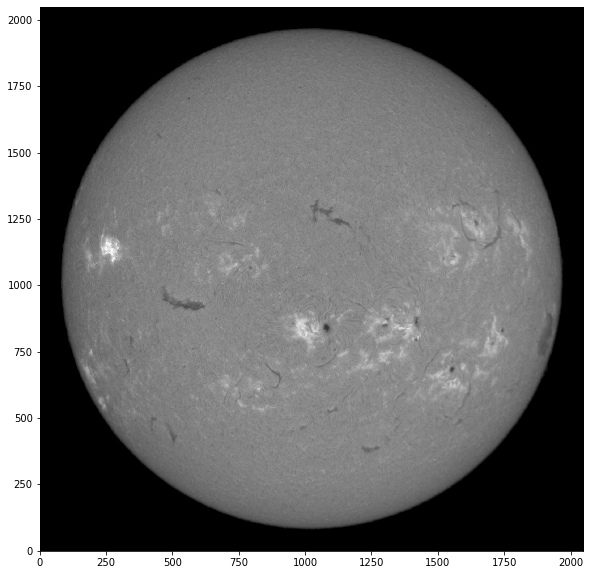

In [12]:
sol_img = image_loading('data/BBSO/fits/bbso_halph_fl_20140708_164624.fts') #add filter, which is assigning user
show_image(sol_img)

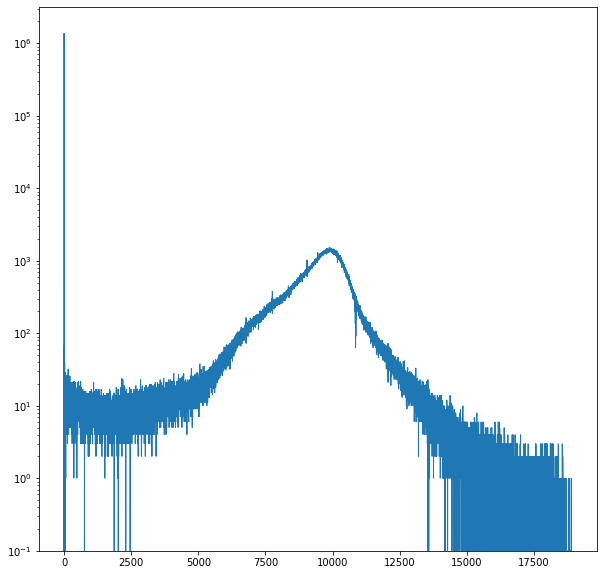

In [13]:
# Displaying histohram using matplotlib library
min_val = np.amin(np.amin(sol_img))
max_val = np.amax(np.amax(sol_img))
histogram = plt.hist(sol_img.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

### Reducing image size (for median filter, using PIL)

In [7]:
# upravit tak, aby funkce byla použitelná i na zvětšení zpět? Nebo napsat druhou funkci OriginalImageSize()?
# zjistit velikosti snímků z observatoří, jež chci používat, aby zmenšený nebyl pak příliš malý!
def size_reduction(image, reduction_coefficient): #pridat parametr něco jako koeficient zmenšení kvůli Hough
    """
    Reduce image size with reduction_coefficient. Or magnify if reduction_coefficient is given as a fraction.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    reduction_coefficient: integer
        Factor used to reduce image shape.
        
     Returns
    -------
    sol_img_small: ndarray
        Output reduced image.
        
    """
    # požadované rozměry zmenšeného obrazu, zmenšuji na čtvrtinu, protože funkce resize z Image transponuje, 
    #musím obrátit pořadí width a height, tj. image.shape[1] je ve skutečnosti height:
    width = int(image.shape[1]/reduction_coefficient)
    height = int(image.shape[0]/reduction_coefficient)
    
    sol_img_small = np.array(Image.fromarray(image).resize((width, height), Image.BILINEAR)) # bilinear, bikubic?
        
    return sol_img_small

Image type:  <class 'numpy.ndarray'> , Image shape:  (512, 512) , Image data type:  int32


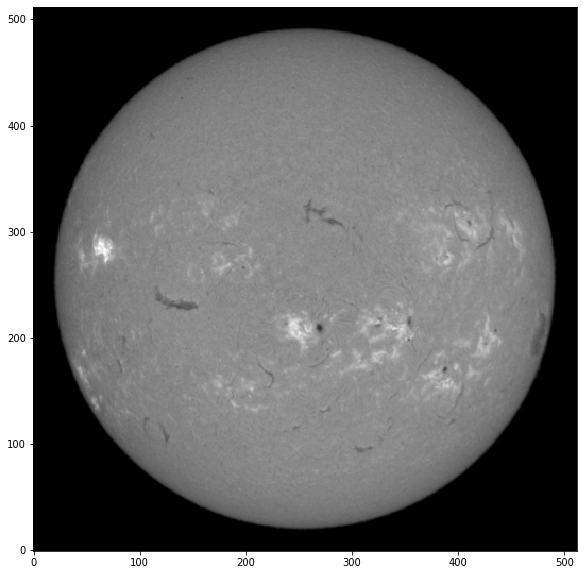

In [8]:
sol_img_small = size_reduction(sol_img, 4)
show_image(sol_img_small)

thresh = threshold_triangle(sol_img_small)
    #thresh = threshold_otsu(image)      
image_for_otsu = sol_img_small > thresh #binary image created 
show_images(sol_img_small, image_for_otsu)
edges = sobel(image_for_otsu)
show_image(edges)

### Hough transform: circle

Postupuji podle příkladu v skimage.

In [8]:
def circle_hough_transform(image):
    """
    Perform a circle hough transform on the input image.
    
    Parameters
    ----------
    image: ndarray
        Input image.
        
    Returns
    -------
    edges: array
        The binary edge map obtained with Sobel filter.
    cx: integer
        X-coordinate of solar disc center.
    cy: integer
        Y-coordinate od solar disc center.
    radius: integer
        Radius of solar disc.
        
    """
    image_for_otsu = np.copy(image)
    thresh = threshold_otsu(image)  #thresh = threshold_triangle(image) for calcium images better - Try for others!    
    image_for_otsu = image > thresh #binary image created  
    edges = sobel(image_for_otsu) #finding edges using Sobel filter
    #show_images(image_for_otsu, edges)

    #hodně kroků, asi zmenšit jen jednou a zmenšovacím koeficientem zvětšit výsledký poloměr a to už pustit na image
    radius_estimation = min(image.shape) / 2
    #print('First estimation of radius as a half of the smaller value from image shape: ', radius_estimation)
    
    #nejspíše není třeba cyklu, původně jsem zmenšovala 5x, pak 2x a teď jen jednou a výsledek stejný...
    for i in range(10, 0, -5):
        #small_image = size_reduction(image_for_otsu, i)
        small_edges = size_reduction (edges, i)
        estimated_val = radius_estimation/i
        hough_radius = np.arange(estimated_val - 10, estimated_val + 10, 1) #určení rozsahu, v kterém hledáme poloměr
        hough_res = hough_circle(small_edges, hough_radius) #akumulátor pro všechny nalezené poloměry a středy cx, cy
        accums, cx, cy, radius = hough_circle_peaks(hough_res, hough_radius, total_num_peaks=1)
        #print("Radius in each step: ", radius)
        radius_estimation = int(radius)*i
        #print('Computed radius for each step: ', radius_estimation)
        
    hough_radius = np.arange(radius_estimation - 10, radius_estimation + 10, 1)
    hough_res = hough_circle(edges, hough_radius)
    accums, cx, cy, radius = hough_circle_peaks(hough_res, hough_radius, total_num_peaks=1)  

    return edges, int(cx), int(cy), int(radius)

In [9]:
def draw_hough_result(image, hough_res):
    """
    Draw results of hough transform - binary edge map and calculated circle or ellipse (according 
    given information) which is drawn into the solar image. Return nothing.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    houg_res: array
        Contain binary edge map, coordinates of solar disc center and solar disc radius in case of
        the circle. Binary edge map, center coordinates, semi-major axis, semi-minor axis and 
        orientation in case of the ellipse.
        
    """
    if len(hough_res) > 4:
        edges, xc, yc, a, b, orientation = hough_res
        image_hough_edge=np.copy(image)
        cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
        image_hough_edge[cy, cx] = np.amax(image) + 1000 

    else:
        edges, cx, cy, radius = hough_res
        image_hough_edge = np.copy(image) #vytvoření proměnné, do které vykreslíme nalezený sluneční okraj
        circy, circx = circle_perimeter(cy, cx, radius,shape=image_hough_edge.shape)
        #obarvení, resp. vyznačení kružnice tak, že si zjistím maximální hodnotu jasu v obrázku a přičtu třeba 1000
        image_hough_edge[circy, circx] = np.amax(image) + 1000 
    
    #vykreslení hranového snímku (canny) a řešení Houghovy transformace
    plt.rcParams['figure.figsize'] = [25, 25]
    plt.subplot(1, 2, 1)
    plt.imshow(edges, cmap=plt.cm.gray, origin='lower')
    plt.subplot(1, 2, 2)
    plt.imshow(image_hough_edge, cmap=plt.cm.gray, origin='lower')
    plt.show()

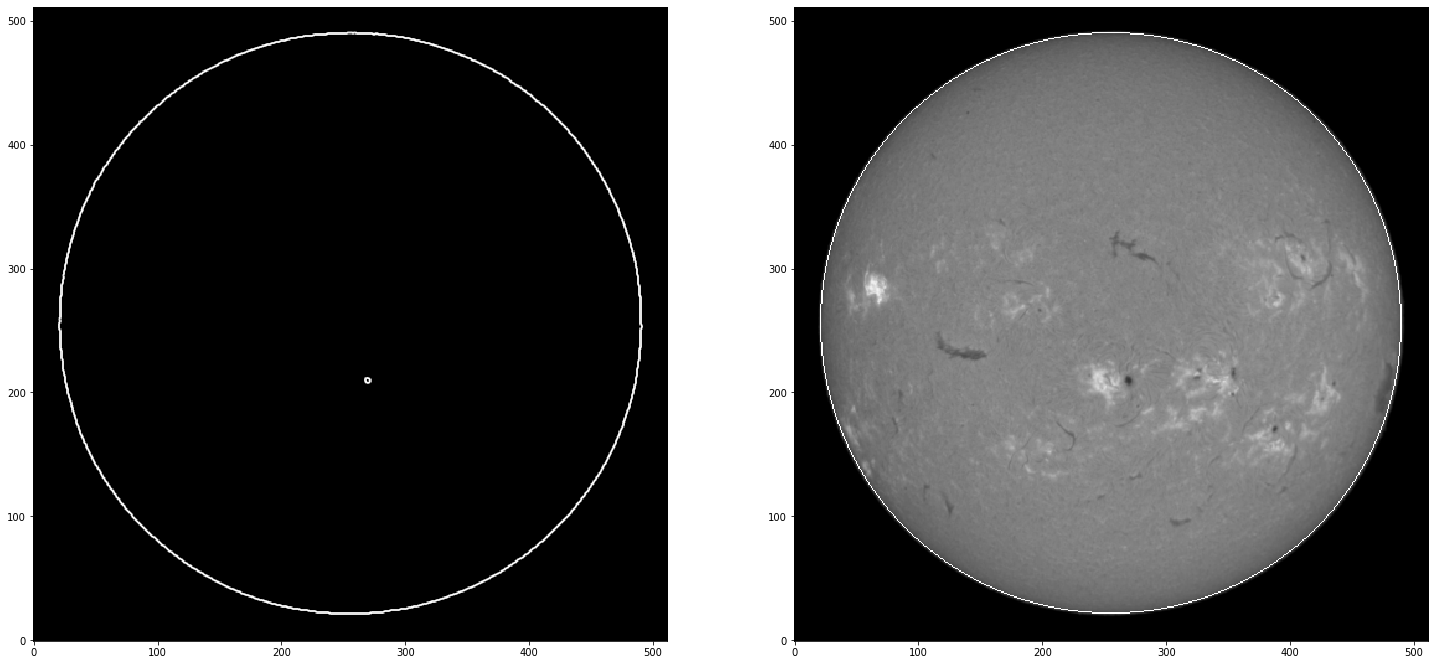

255 256 234


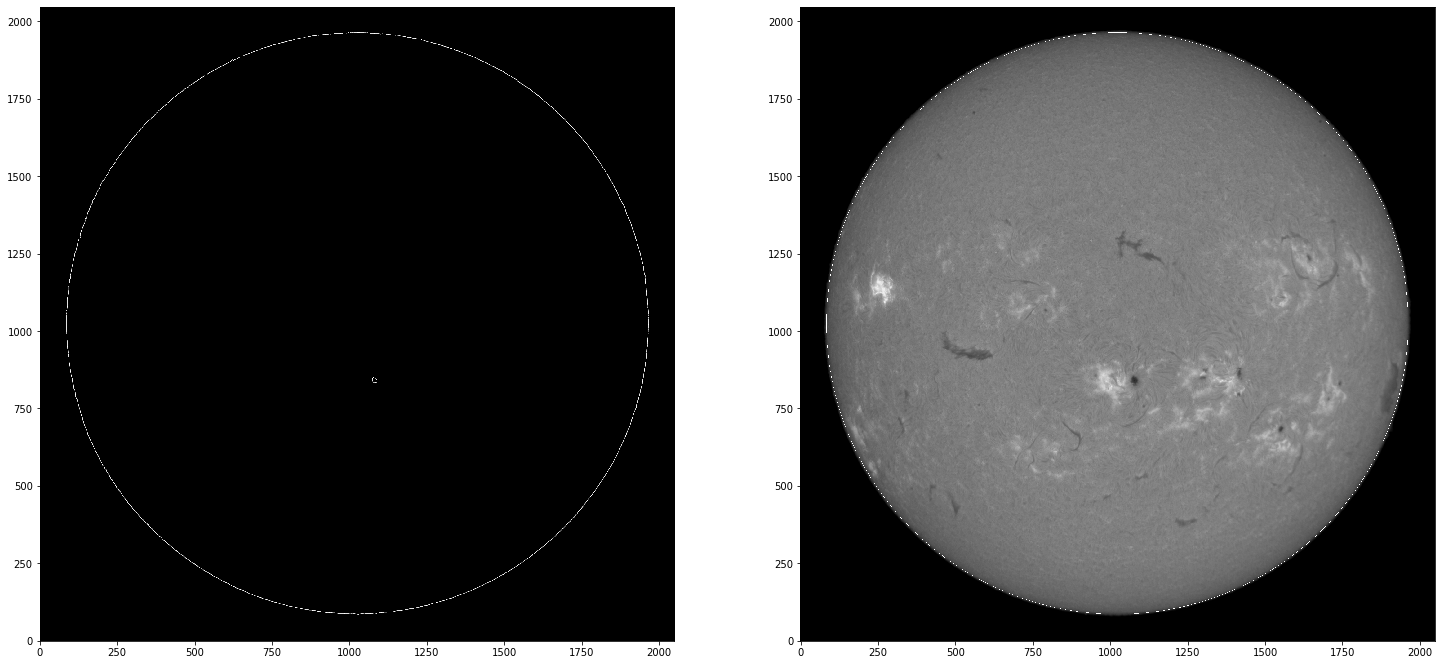

1023 1024 938


In [10]:
#Houghova transformace pro zmenšený snímek
hough_res = circle_hough_transform(sol_img_small)
hough_res_drawing = draw_hough_result(sol_img_small, hough_res)
edges, cx, cy, radius = hough_res #cx, cy určitě správně, ověřeno na obdélníkovém snímku (Hvězdárna Val.Meziříčí)
print(cx,cy,radius)

#Houghova transfromace a její výsledky pro snímek s původní velikostí, nefunguje dobře na sol_img, ale 
#na sol_img_nld_big ano, aspoň o KSO... ještě podívat, asi bych měla počíta na původním snímku
hough_res_big = circle_hough_transform(sol_img)
drawing_new = draw_hough_result(sol_img, hough_res_big)
edges_big, cx_big, cy_big, radius_big = hough_res_big 
print(cx_big,cy_big,radius_big)

### Hough transform: ellipse

Postupuji podle příkladu v skimage. Je potřeba podstatně delší čas (cca 5 min), hledám 5 parametrů místo 3, jak tomu bylo u kružnice. Nefunguje na HVM.

In [11]:
def ellipse_hough_transform(image, circle_radius):
    """
    Perform an ellipse hough transform on the input image.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    circle_radius: integer
        Radius calculated with circle_hough_transform function.
    
    Returns
    -------
    xc: integer
        X-coordinate of elliptical solar disc center.
    yc: integer
        Y-coordinate of elliptical solar disc center.
    a: integer
        Semi-major axis.
    b: integer
        Semi-minor axis.
    orientation: double
        Major axis orientation in clockwise direction as radians.
        
    """    
    # Perform a Hough Transform
    # The accuracy corresponds to the bin size of a major axis.
    # The value is chosen in order to get a single high accumulator.
    # The threshold eliminates low accumulators
    
    image_for_otsu = np.copy(image)
    thresh = threshold_otsu(image)
    image_for_otsu = image > thresh 
    edges = img_as_bool(sobel(image_for_otsu))

    #zkusit vzít výsledky kruhové hough transformace a použít pro zmenšení rozsahu min_size a max_size
    # spustit na zmenšený obrázek a pak postupně zvětšovat
    variance = int(circle_radius * (5/100)) #max variace as a 5% of radius from circle Hough transform
    
    min_ax = circle_radius - variance
    max_ax = circle_radius + variance
    
    #result obsahuje mnoho šestic, každá šestice je (max_hist = accumulator, yc, xc, a, b, orientation)
    #accuracy: bin_size = accuracy * accuracy! Musí být dostatek binů
    result = hough_ellipse(edges, accuracy=25, threshold=250, min_size=min_ax, max_size=max_ax)
    result.sort(order='accumulator') #accumulator je hodnota každá 'max_hist' větší jak threshold

    # Estimated parameters for the ellipse
    best = list(result[-1]) #vypisuje chybu pro jeden snímek s erupcemi, prostudovat si tuto část a opravit!!!
    yc, xc, a, b = [int(round(x)) for x in best[1:5]]
    orientation = best[5]
   
    return edges, xc, yc, a, b, orientation

#štvát jen na malý snímek, ten pak upravit na kruh a z takovéh snímku až počítat i velký poloměr
#elipsa bude vždycky trvat dlouho! Čím větší snímek, tím hůř...
hough_res_el = ellipse_hough_transform(sol_img_small, radius) 

hough_res_drawing = draw_hough_result(sol_img_small, hough_res_el)

print('xc, yc, a, b, orientation: ', hough_res_el[1], hough_res_el[2], hough_res_el[3], hough_res_el[4], 
      hough_res_el[5])

In [12]:
#Compute ellipse hough transform time
#def ellipse_hough_time():
    
#    ellipse_hough_transform(sol_img_small, radius)
  
   
#print(timeit.timeit("ellipse_hough_time()", setup="from __main__ import  ellipse_hough_time"), number=10)

### Resampling of elliptical solar disc to circular shape

In [13]:
#Zde prijde kus kódu pro transfromaci eliptickeho slunečního disku na kruhový
#if a =! b than resample to cirkular shape, resp. if |a-b| > přípustná odchylka pár pixelů (procentuálně z velikosti
# obrázku)

### Obtaining the arithmetic mean of the solar disk, frequently used value

In [14]:
def get_mean(image, radius, center):
    """
    Calculate mean value from given (supposedly solar) disc and creates constant array from this value.
    
    Parameters
    ----------
    image: ndarray
        Image containing disc from which arithmetic mean calculation is required.
    radius: integer
        Solar disc radius expected.
    center: list with only two values
        Solar disc center coordinates expected.
    
    Returns
    -------
    mean_img: array
        Return constant array (filled with one value calculeted as a arithmetic mean from 
        given disc - solar disc, median mask, limb darkening mask etc.).
    
    """
    cx, cy  = center
    width, height = image.shape
    data_for_mean = []
    for x in range(0, width):
        for y in range(0, height):
            if (cx - x)**2 + (cy - y)**2 <= (radius - 40)**2:
                data_for_mean.append(image[y,x])
    
    #nevracet pole, ale jen jednu hodnotu a pak kde potřebuju pole, přidám np.full(GetMean...)!!!!!!
    return np.full(image.shape, np.round(sum(data_for_mean) / len(data_for_mean))) 
#return np.full(image.shape, np.round(sum(sum(image)) / (image.shape[0]*image.shape[1])))

In [15]:
mean_array = get_mean(sol_img_small, radius, [cx, cy])
print(mean_array.shape, mean_array[0][0])

(512, 512) 10017.0


### Image defects detection

In [16]:
#def image_defects_controller(image, a, b): #a, b poloosy elipsy
    #kontrola kvadrantů, když je jeden výrazně jiný než ostatní, pak chyba č. 1
#    if ... :
#        num = 1 
    #deformovaný snímek (kontrola poloos, moc jiné, pak chyba č. 2)
#    if ... :
#        num = 2 
    #zdá-li se vše být OK
#    else:
#        num = 0 
#    return 
    

### Limb darkening removal

S použitím Houghovy transformace. Snímek převedu z kartézských do polárních souřadnic za pomoci výsledků z Houghovy transformace. Dostanu obrázek, kde vertikální osa bude r, horizontální bude fí. Vypočtu medián každého řádku (to jest podél konstantního r), uložím do seznamu. Fituji tento seznam vhodným polynomem, abych našla funkční závislost pro okrajové ztemnění. Vytvořím masku. Vydělím snímek maskou. Vynásobím vhodným faktorem pro upravení hodnoty intenzity pozadí.

#### Transformation from cartesian to polar coordinates, mapped onto a rectangular grid

In [17]:
#Převod do polárních souřadnic pomocí polarTransform, defaultně bikubická, lze změnit
def transform_to_polar(image, hough_res):
    """
    Transform solar image from cartesian coordinates to polar coordinates. 
    
    Parameters
    ----------
    image: ndarray
        Input image.
    hough_res: array 
        Contain  results from circle hough transform. Image edge map, 
        coordinates x and y of solar disc center and solar disc radius.
        
    Returns
    -------
    warped: ndarray
        Solar disc from input image in polar coordinates.
        
    """
    edges, cx, cy, radius = hough_res
    warped = (polarTransform.convertToPolarImage(image, center=(int(cx), int(cy)), finalRadius=int(radius), 
                                                 radiusSize=int(radius), angleSize=360))[0].T
    
    return warped

Image type:  <class 'numpy.ndarray'> , Image shape:  (234, 360) , Image data type:  int32


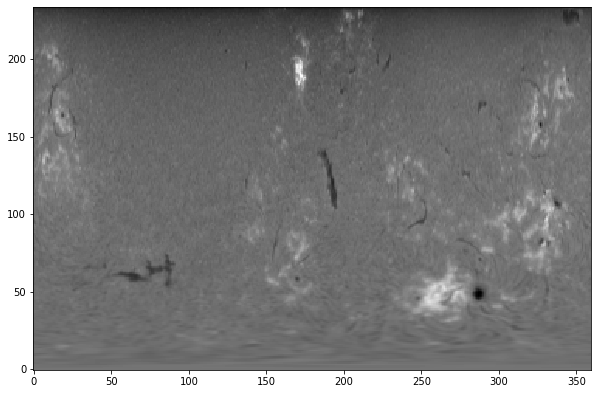

In [18]:
polar_img = transform_to_polar(sol_img_small, hough_res)
show_image(polar_img)

#### Median of each row corresponding to polar coordinate r saved as list_of_medians

In [19]:
#odříznout body ve středu či málo husté oblasti, resp. v následujícím fitovat jen od určité vzdálenosti od středu
def median_of_rows(polar_image):
    """
    Compute median of each row from input image.
    
    Parameters
    ----------
    polar_image: ndarray
        Image of solar disc in polar coordinates.
        
    Returns
    -------
    list_of_medians: list
        Each value in the returned list represents median of corresponding row.
        
    """    
    #rectangular image after transformation to polar coordinates required
    list_of_medians=[]
    for row in polar_image:
        #if 
        list_of_medians.append(statistics.median(row))
    
    return list_of_medians

<class 'list'>


Text(0.5, 1.0, 'Observatoř ...')

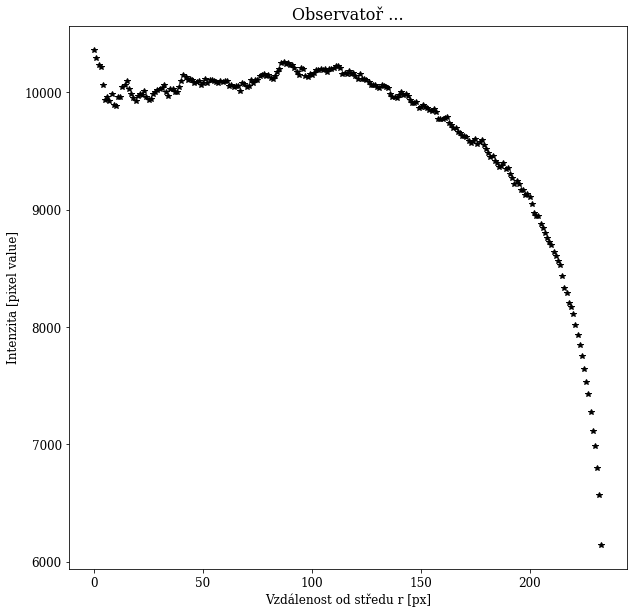

In [20]:
list_of_medians = median_of_rows(polar_img)
print(type(list_of_medians))
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size']=12
plt.rcParams['font.family'] = ['Serif']
plt.plot(list_of_medians, '*', color='black', markersize=6) #color='limegreen'
plt.xlabel('Vzdálenost od středu r [px]')
plt.ylabel('Intenzita [pixel value]')
plt.title('Observatoř ...', fontsize=16)

#### Fitting of list_of_medians by low-order polynomial function - limb darkening function

In [21]:
#fit pomocí metody nejmenších čtverců
#rozdělit asi na tři funkce, jednak získání dat, jednak func a jednak vypočtení fitu
def data_for_fit(list_of_medians, radius):
    
    #nastavit omezení relativně!!! čili nezačínat pevně od 50 pixelů do r-10, co když je to snímek 64 x 64? :-D
    #hodnoty od cca 50 po poloměr disku (radii - cca 10), tj. max délka list_of_medians krom středové oblasti a limbu
    x_data = np.arange(int(0.15*radius), len(list_of_medians)-int(0.015*radius), 1)
    max_value = max(list_of_medians)
    y_data = list_of_medians[int(0.15*radius):len(list_of_medians)-int(0.015*radius)]

    return max_value, x_data, y_data

In [22]:
#Zadefinování funkce popisující okrajové ztemnění, podle článku Solar Limb Darkening(Bayley, Boogert) z r. 2015
#Je třeba namapovat konstanty a0, a1, a2 od 0 po 1! bacha na jednotky!
def fit_function(x, a0, a1, a2):
    
    mi = np.sqrt(1 - x**2) #co s případem, kdy pod odmocninou bude záporné číslo?
    return a0 + a1 * mi + 2* a2 * mi**2

In [23]:
def limb_darkening_fit(fit_function, x_data, y_data, radius):
    
    #Vypočtení vhodného fitu a jeho vykreslení
    x = x_data / radius    
    popt, pcov = curve_fit(fit_function, x, y_data)
         
    return popt

In [24]:
x_data = data_for_fit(list_of_medians, radius)[1]
y_data = data_for_fit(list_of_medians, radius)[2]
ld_fit = limb_darkening_fit(fit_function, x_data, y_data, radius)
print(ld_fit)

[ 5316.52187868  9813.16441577 -2495.47460132]


In [25]:
yplot = fit_function(x_data / radius, *ld_fit) #nesmíš zapomenout podělit poloměrem!

In [1]:
#vyhodit kreslící věci jinam
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size']=16
plt.rcParams['font.family'] = ['Serif']
plt.plot(list_of_medians, '*', color='black', markersize=6, label='median pixel values')
plt.plot(x_data, yplot, 'r-', linewidth=3, label='fit: a = {0:5.3f}, b = {1:5.3f}, c = {2:5.3f}'.format(*ld_fit))
plt.xlabel('Distance from the center r [px]')
plt.ylabel('Intensity [pixel value]')
plt.legend(loc='best', bbox_to_anchor=(0.9, 0.2))
plt.title('Observatory BBSO', fontsize=20)

NameError: name 'plt' is not defined

Image type:  <class 'numpy.ndarray'> , Image shape:  (234, 360) , Image data type:  float64


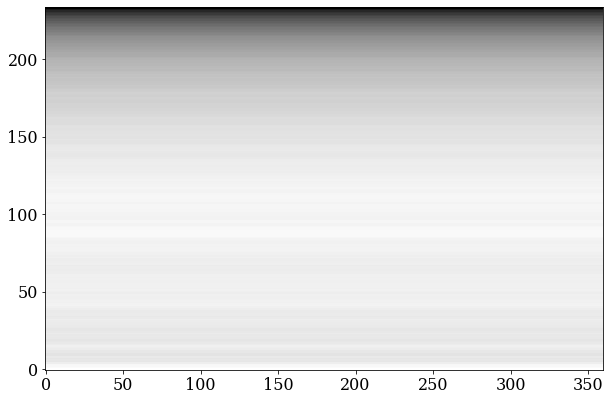

In [27]:
# Vytvoření masky pomocí list_of_medians: každou hodnotu roztáhnout na jeden řádek (pro srovnání s maskou z fitu)
# lze vidět, proč je třeba vynechat středovou oblast, značně ji narušuje, vyskytuje-li se zde pláž
# zde je jen pro srovnání s maskou z fitu, nepoužije se již nikde dále
medians_mask = np.repeat(list_of_medians, polar_img.shape[1]).reshape(polar_img.shape)
show_image(medians_mask)

In [28]:
#vytvoření masky za pomocí funkce okrajového ztemnění s výsledky metody nejmenších čtverců (tato dále použita)
def limb_darkening_mask_calculation(fit_function, each_row_median_list, popt, polar_image_size):
    """
    Create limb darkening mask from limb darkening fit. 
    
    Parameters
    ----------
        list_of_medians: list
            Each value in the list represent median of corresponding row.
        popt: ndarray
            Three constants - results of limb darkening fit. 
        polar_image_size: tuple of two integer values 
            Shape of solar image in polar coordinates.
    
    Returns
    -------
    polar_fit_mask: ndarray
        Limb darkening mask computed from limb darkening function, still in polar 
        coordinates.
    
    """
    #x, y = polar_image_size
    a, b, c = popt
    radius = len(each_row_median_list)
    medians_fit_values = fit_function(np.arange(0.0, radius, 1) / radius, a, b, c)
    polar_fit_mask = np.repeat(medians_fit_values, polar_image_size[1]).reshape(polar_image_size)
    
    return polar_fit_mask

Image type:  <class 'numpy.ndarray'> , Image shape:  (234, 360) , Image data type:  float64


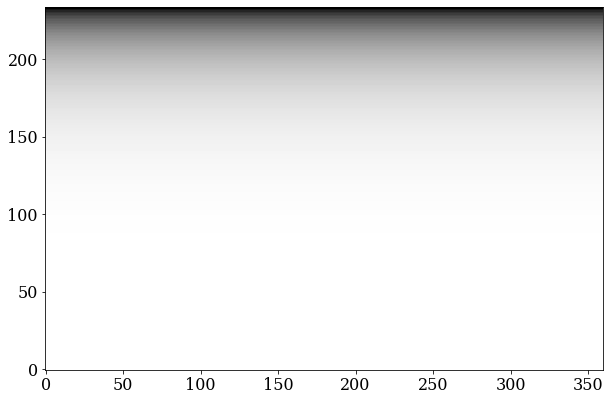

In [29]:
polar_fit_mask = limb_darkening_mask_calculation(fit_function, list_of_medians, ld_fit, polar_img.shape)
show_image(polar_fit_mask)

$\textbf{Transformation from polar to cartesian coordinates}$

In [30]:
#převod masky do kartézských souřadnic, oblasti za okrajem disku vyplnit asi??? borderVal???
def transform_to_cartesian(mask, image_size, hough_res, mean_value):
    """
    Transform limb darkening mask from polar coordinates to cartesinan coordinates.
    
    Parameters
    ----------
    mask: ndarray
        Calculated mask of limb darkening in polar coordinates.
    hough_res: array
        Contain  results from circle hough transform. Image edge map, 
        coordinates x and y of solar disc center and solar disc radius.
    mean_value: integer
        Value for background surrounding solar disc, taken from mean_array 
        computed earlier with function get_mean(image, radius, center).
        
    Returns
    -------
    limb_darkening_mask: ndarray
        Image of limb darkening mask in cartesian coordinates 
        with defined border value outside the solar disc.
        
    """
    edges, cx, cy, radius = hough_res         
    limb_darkening_mask = polarTransform.convertToCartesianImage(mask.T, center = (cx, cy), border='constant',
                                                                 borderVal=mean_value, imageSize=image_size)
    #maska pro úpravy snímků s původní velikostí!!!
    #limb_darkening_mask_big = polarTransform.convertToCartesianImage(mask.T, center = (CX, CY), border='constant',
    #                                                            borderVal=600.0, imageSize=sol_img.shape)
    
    return limb_darkening_mask[0]#, limb_darkening_mask_big[0]

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float32


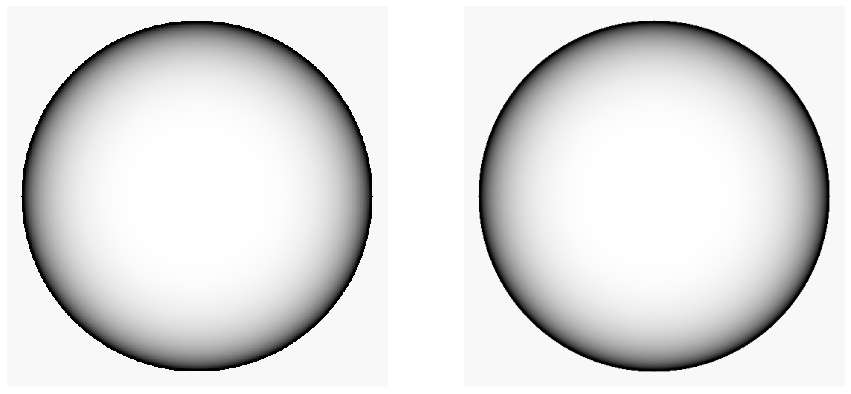

In [31]:
#Možná udělat tak, že upravím rozsah intezit masky tak, aby to bylo mezi 1 - něco, lepší pro dělení níže
limb_darkening_mask = transform_to_cartesian(polar_fit_mask, sol_img_small.shape, hough_res, mean_array[0][0])
#limb_darkening_mask_big = np.array(Image.fromarray(limb_darkening_mask).resize(sol_img.T.shape, Image.BILINEAR))
limb_darkening_mask_big = size_reduction(limb_darkening_mask, 1/4)
show_images(limb_darkening_mask, limb_darkening_mask_big)
#show_image(limb_darkening_mask_big)

In [32]:
def limb_darkening_removal(image, mask, mean_value):
    """
    Remove limb darkening from solar image.
    
    Paramaters
    ----------
    image: ndarray
        Solar image expected.
    mask: ndarray
        Mask calculated from limb darkening function expected.
    mean_value: integer
        Arithmetic mean calculated from mask expected.
    
    Returns
    -------
    sol_img_nld: ndarray
        Solar image with no limb darkening at the best case.
        
    """    
    sol_img_nld = (image / mask) * mean_value
 
    return sol_img_nld

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  int32
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


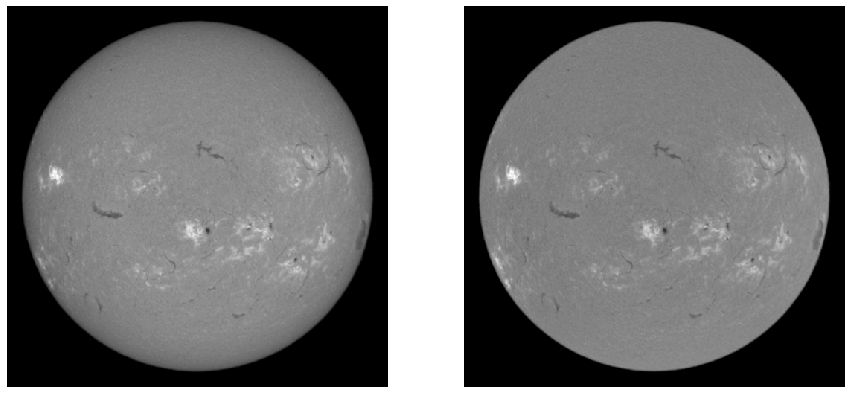

In [33]:
sol_img_nld = limb_darkening_removal(sol_img_small, limb_darkening_mask, mean_array[0][0])
sol_img_nld_big = limb_darkening_removal(sol_img, limb_darkening_mask_big, mean_array[0][0])
#show_images(sol_img)
#show_image(sol_img_nld_big)
show_images(sol_img_small, sol_img_nld)

### Elimination of non-radial variation

Valentina Zharkova's algorithm. 

We reduce original image size. Median from reduced image (with large structuring element) and mean of median are computed. Than normalised image is computed as follows:
- substract median filter from the original image, than back to original intensity level (mean median addition)
- now we need to locate pixel corresponding to bright and dark regions, so we define two suitable tresholds
- we find maximum y - value H_M from histogram, the value which has the most pixels (pixels of quiet solar disc)
- we find intensity level V_M corresponding to the most frequent value H_M
- we locate intensity value V1 corresponding to H_M / a1 (V1 < V_M) and V2 corresponding to H_M / a2 (V2 > V_M)
- a1, a2 are constants (which are not specified in original article)
- we create the set S, this set contains values out of the range [V1, V2]
- than we replace values from set S with their corresponding values from median filter, this step eliminates too dark and too bright places by replacing them with median values -> sol_img_small_norm[S] = median_mask[S]
- now we have image normalised in the first step with median filter with large structuring element and with solar features replaced with median values
- from this normalised image we compute median filter with smaller structuring element (half of the size) 
- now we enlarge this median filter to the original image size
- we substract this median filter from original image and add newly computed mean median array to fix background intensity level
- DONE

In [34]:
#nezapomenout: pořadí souřadnic je správně asi takto: [y,x]!!!

In [35]:
def first_median_filtering(image, radius, center):
    """
    Fuller algorithm (or Zharkova?). Normalised solar image is computed as follows:
    normalised solar image = input image - median mask + arithmetic mean of the median mask
    
    Paramaters
    ----------
    image: ndarray
        Solar image with no limb darkening.
    radius: integer
        Solar disc radius.
    center: list with two integer values
        Solar disc center coordinates.
    
    Returns
    -------
    sol_img_small_norm: ndarray
        Solar image with large scale non-radial variations removed.
    median_mask: ndarray
        Median mask computed with large structuring element from input solar image. SE needs odd number of pixels.
    
    """       
    median_mask = median(image, square(49), behavior='ndimage', mode='wrap') 
    mean_median_mask = get_mean(median_mask, radius, center) 
    cx, cy = center
    
    sol_img_small_norm = np.copy(image)
    width, height = image.shape
    for x in range(0, width):
        for y in range(0, height):
            if (cx - x)**2 + (cy - y)**2 <= (radius)**2:
                sol_img_small_norm[y,x] = image[y,x] - median_mask[y,x] + mean_median_mask[y,x]
  
    return sol_img_small_norm, median_mask 

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


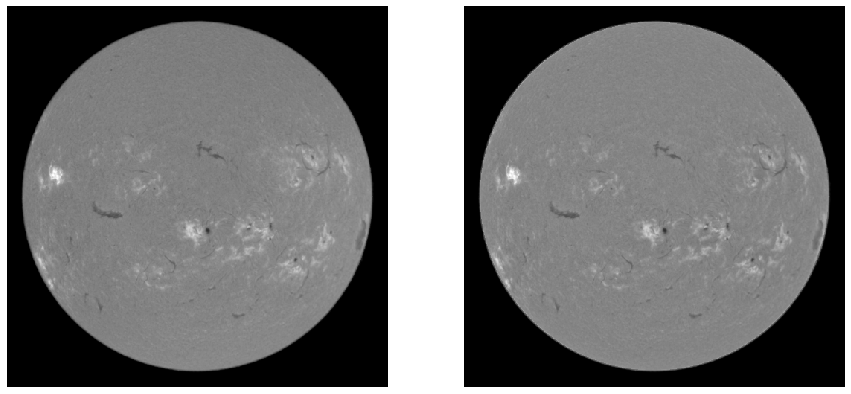

In [36]:
sol_img_small_norm, median_mask = first_median_filtering(sol_img_nld, radius, [cx, cy])
show_images(sol_img_nld, sol_img_small_norm)

In [37]:
def solar_feature_removal(image, median_mask, a1=100, a2=100):
    """
    Takes the input image which is after first median filtering and calculates two suitable thresholds for
    replacing pixel values corresponding to the solar features by values from median mask at the same position. 
    
    Paramaters
    ----------
    image: ndarray
        Solar disc after first median filtering (median filter with large structure element).
    median_mask: ndarray
        Median mask computed from solar image with no limb darkening using large SE.
    
    Returns
    -------
    V_M: integer
        The most frequent intensity value on the solar disc.
    V1: integer
        Threshold value V1 < V_M for removing dark features from solar disc.
    V2: integer
        Threshold value V2 > V_M for removing bright features from solar disc.
    no_feature_img:ndarray
        Image with solar feature removed using thresholds V1 & V2.
        
    """    
    #Pro určení počtu binů
    min_val = np.amin(np.amin(image))
    max_val = np.amax(np.amax(image))
    print('Minimum and maximum values in list: ', min_val, max_val)

    #y je seznam četností, amax najde největší četnost
    plt.rcParams['figure.figsize'] = [5, 5]
    y, x, _ = plt.hist(image.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

    #zde pomocí Otsuova prahování odstranění pvrvní části bimodálního histogramu, která odpovídá oblasti
    #mimo disk!!!!
    thresh = threshold_otsu(image)
    #x_beginning = np.where(x == thresh)
    idx = (np.abs(x - thresh)).argmin()
    #ze seznamu y odstranit vše, co je menší jako x = thresh!
    print('Práh pro odstranění pozadí ze seznamů četností a intenzit: ', thresh)
    print('Hodnota intenzity, od které bude vše menší odstraněno ze seznamu intenzit: ', x[idx])
    x = x[idx:]
    y = y[idx:]
    # H_M je nejvyšší četnost v histogramu  (osa y), V_M je odpovídající hodnota na ose x
    H_M = np.amax(y)
    H_M_position = np.where(y == H_M) # H_M_position je index v příslušném poli y, kde se nachází H_M, nefunguje pro BBSO
    ### H_M_position je tuple of tuples/arrays, H_M_position[0] je pole s pozicí maxim, (H_M_position[0])[0] už číslo:
    H_M_position = (H_M_position[0])[0] 
    V_M = x[H_M_position] # hodnota pixelu s největší četností, resp. odpovídající 'bin'

    print('Maximum histogram frequency H_M: ', H_M)
    print('Position of H_M in list:  ', H_M_position)
    print('Intensity value corresponding to H_M: ', V_M)
    
    ### Nyní chceme najít hodnoty (V1 odpovídá H_M / a1) < V_M a (V2 odpovídá H_M / a2) > V_M; co jsou a1 a a2????
    #odhad konstant H1, H2 (asi a1 a a2 u Zharkové), hledám v polovině logaritmické křivky
    #a1 = 100
    #a2 = 100 #posunout tak, aby V2 bylo blíže k V1, špatně kryje pláže
    const_estimate1 = H_M / a1
    const_estimate2 = H_M / a2
    print('Estimated frequences H1 and H2 using constant a1, a2: ', const_estimate1, ', ', const_estimate2)

    #hledat od vrcholu, od vrcholu doleva a doprava...
    H1_position = (np.abs(y[:H_M_position][::-1] - const_estimate1)).argmin() #hledám hodnotu zleva, nejblíž k odhadované kostantě
    H2_position = (np.abs(y[H_M_position:] - const_estimate2)).argmin() #hledám hodnotu zprava, nejblíž k odhadované kostantě
    H1_position = H_M_position - H1_position - 1
    H2_position = H_M_position + H2_position
    print('Found frequencies H1 and H2: ', y[H1_position], ', ', y[H2_position])
    print('Positions of nearest frequency values to H1, H2: ', H1_position, ', ', H2_position)

    V1 = x[H1_position]
    V2 = x[H2_position]
    print('Intensity value V_M, corresponding to H_M: ', V_M, ', ', H_M)
    print('Intensity values V1, V2 corresponding to H1, H2 (sunspots, filaments, flares, plages): ', V1, ', ', V2)
    ### vše, co je venku z rozsahu V1 - V2 (<0,V1) U (V2, 512>), nahradíme v sol_img_small_norm pixely z median_mask
    #na obdélníkovém snímku nefunguje..
    no_feature_img = np.copy(image)
    width, height = no_feature_img.shape

    #tady pozor! Pro snímek z HVM jsem musela obrátit height a width v cyklech, zkusit znovu na KSO!!!
    for x in range(0, height):
        for y in range(0, width):
            if (no_feature_img[y,x] < V1 or no_feature_img[y,x] > V2):
                no_feature_img[y,x] = median_mask[y,x]           
    
    return V_M, V1, V2, no_feature_img

Minimum and maximum values in list:  0.0 19434.021887440325
Práh pro odstranění pozadí ze seznamů četností a intenzit:  5048.290841854616
Hodnota intenzity, od které bude vše menší odstraněno ze seznamu intenzit:  5048.0056852834605
Maximum histogram frequency H_M:  296.0
Position of H_M in list:   5090
Intensity value corresponding to H_M:  10138.0114178692
Estimated frequences H1 and H2 using constant a1, a2:  2.96 ,  2.96
Found frequencies H1 and H2:  3.0 ,  3.0
Positions of nearest frequency values to H1, H2:  4353 ,  6035
Intensity value V_M, corresponding to H_M:  10138.0114178692 ,  296.0
Intensity values V1, V2 corresponding to H1, H2 (sunspots, filaments, flares, plages):  9401.010587826824 ,  11083.012482170481


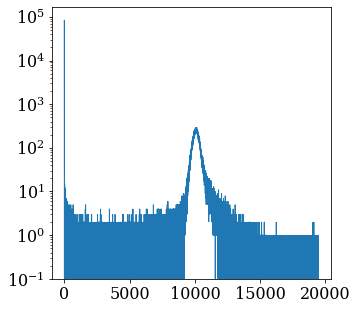

In [38]:
V_M, V1, V2, no_feature_img = solar_feature_removal(sol_img_small_norm, median_mask)

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


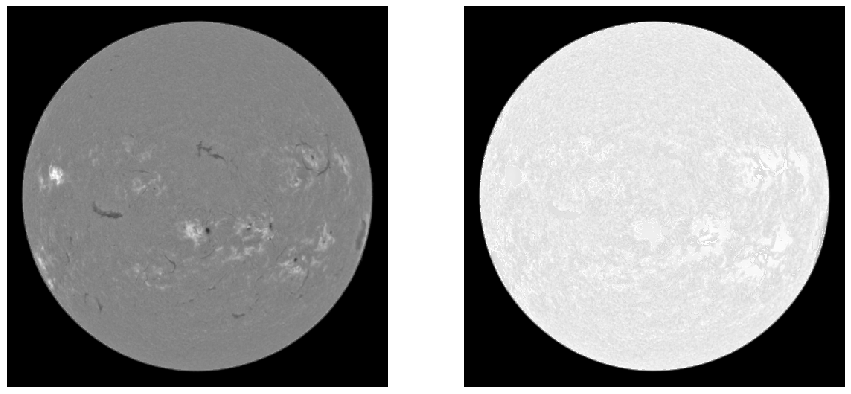

In [39]:
show_images(sol_img_small_norm, no_feature_img)

In [40]:
def nonradial_variation_removal(no_feature_image, original_image, center, radius_big, sol_img_nld_big):
    """
    Takes input image with solar feature removed, creates median mask from this image with 
    smaller structuring element as previously (half of the size of the first median filter 
    SE) and follows the same procedure as in first median filtering. Returns normalised 
    image with original solar image size.
    
    Paramaters
    ----------
    no_feature_image: ndarray
        Solar image with solar features removed.
    original_image: ndarray
        Solar image with original image size.
    center: list of two integer values
        Solar disc center coordinates calculated from original image (original size).
    radius_big: integer
        Solar disc radius calculated from original image (original size).
    sol_img_nld_big: ndarray
        Solar image with no limb darkening and with original solar image size.
    
    Returns
    -------
    sol_img_norm: ndarray
        Normalised solar image - with non-radial variations removed.
    median_mask_second_big: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    """       
    #SE as a disk raise error!!!
    cx_big, cy_big = center
    median_mask_second = median(no_feature_image, square(25), behavior='ndimage', mode='wrap')
    median_mask_second_big = np.array(Image.fromarray(median_mask_second).resize((original_image.T.shape), 
                                                                                 Image.BILINEAR))
      
    mean_median_mask_second_big = get_mean(median_mask_second_big, radius_big, [cx_big, cy_big])        
   
    # Formula applied: sol_img_norm = sol_img - SM + mean(SM)
    sol_img_norm = np.zeros_like(original_image)#np.copy(sol_img_nld_big)
    width, height = sol_img_nld_big.shape

    for x in range(0, height):
        for y in range(0, width):
            if (cx_big - x)**2 + (cy_big - y)**2 <= radius_big**2:
                sol_img_norm[y,x] = (sol_img_nld_big[y,x] - median_mask_second_big[y,x] + 
                                     mean_median_mask_second_big[y,x])
            
    return sol_img_norm, median_mask_second_big

In [41]:
sol_img_norm, median_mask_second_big = nonradial_variation_removal(no_feature_img, sol_img, [cx_big, cy_big],
                                                                   radius_big, sol_img_nld_big)

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  >i2
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  >i2


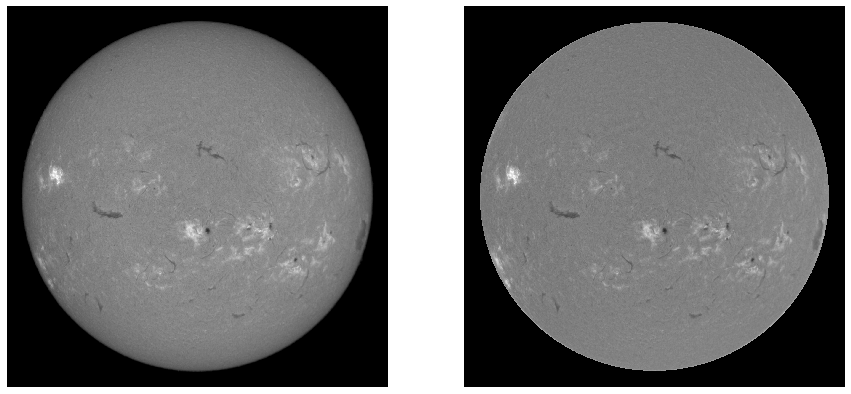

In [42]:
show_images(sol_img, sol_img_norm)

### Global thresholding

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                      range=(350, 700), log=True)

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img_norm.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                     range=(350, 700), log=True)

Image type:  <class 'numpy.ndarray'> , Image shape:  (2048, 2048) , Image data type:  int16


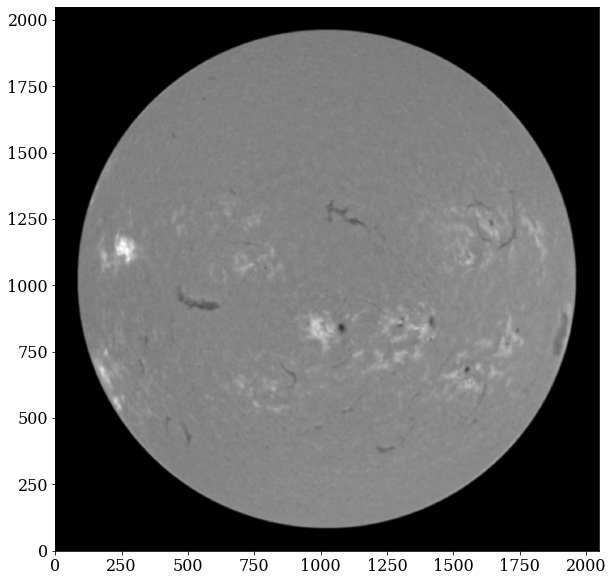

In [43]:
gaussian_img = ndimage.gaussian_filter(sol_img_norm, 3)
show_image(gaussian_img)

### For histogram displaying
min_val = np.amin(np.amin(sol_img_norm))
max_val = np.amax(np.amax(sol_img_norm))
print('Minimum and maximum values in list: ', min_val, max_val)

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img_norm.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

In [44]:
###Globální prahování
def global_thresholding(image, thresh):
    
    width, height = image.shape
    binary = np.empty(image.shape)
    for x in range(0, height):
        for y in range(0, width):
            if (cx_big - x)**2 + (cy_big - y)**2 <= radius_big**2 and image[y,x] > thresh:
                binary[y,x]=True
            else:
                binary[y,x]=False          
  
    return binary

In [45]:
binary = global_thresholding(sol_img_norm, mean_array[0,0])

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  >i2
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float64


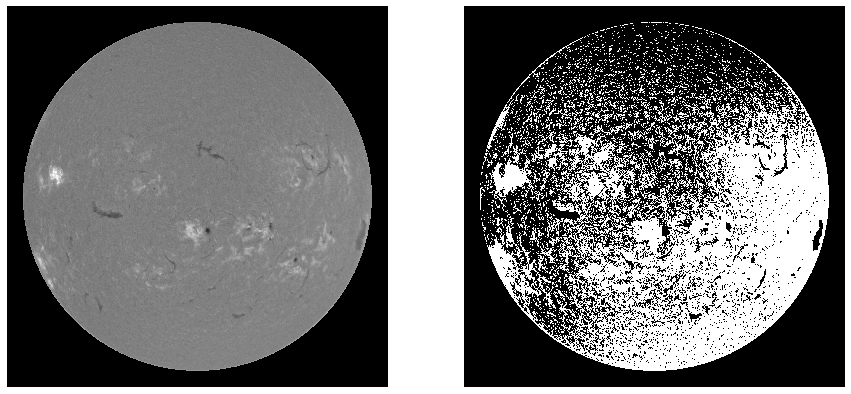

In [46]:
show_images(sol_img_norm, binary)

### Segmentation of sunspots and filaments

In [47]:
#lokální prahování pro tmavé oblasti narušují příliš světlé oblasti, funkce threshold_local pak totiž
#označuje oblasti kolem světlých pláží a erupcí jako detekované tmavé oblasti, proto je třeba
#světlé oblasti eliminovat, nejspíše použitím prahu V2 z algoritmu Zharkové
def dark_feature_extraction(image, median_mask, center, radius_big, mean_value, V2):
    """
    Uses local thresholding and mathematical morphology to extract dark features from solar disc.
    
    Paramaters
    ----------
    image: ndarray
        Normalised solar image (with limb darkening and non-radial variations removed).
    median_mask: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    center: list with two integer values
        Solar disc center coordinates computed from original image (original size).
    radius_big: integer
        Solar disc radius computed from original image (original size).
    
    Returns
    -------
    dark_experimental_img: ndarray
        Solar image with too bright regions removed from solar disc (using V2 threshold 
        from Zharkova algorithm).
    dark_binary_local: ndarray
        Binary image obtained from local thresholding.
    dark_binary_local_nl:
        Binary image obtained from local thresholding with solar limb assign to
        the background.
    dark_eroded:
        Binary image calculated with binary morphological erosion operator.
    dark_reconstructed:
        Eroded binary image morphologically reconstructed.
    dark_without_small_objects:
        Binary image with too small object removed.
    
    """
    
    cx_big, cy_big = center
    dark_experimental_img = np.copy(image)
    width, height = dark_experimental_img.shape
    for x in range(0, height):
        for y in range(0, width):
            if (dark_experimental_img[y,x] > V2):
                dark_experimental_img[y,x] = median_mask[y,x]

    #gaussovský filtr odstraní mnoho šumu! Ale taky naruší detekci slabých útvarů...
    #bacha na sigma!
    dark_experimental_img = ndimage.gaussian_filter(dark_experimental_img,3) 
    #nebo nejprve zaostřit a pak gaussovsky rozmazat a eliminovat tak šum:
    #dark_experimental_img = ndimage.gaussian_filter(dark_experimental_img + 
    #                                                ndimage.gaussian_laplace(dark_experimental_img,3),3)
    #show_image(dark_experimental_img)
    
    #prahování pomocí "posouvacího okna", z nějž je spočten medián a s touto hodnotou je porovnáván zkoumaný pixel
    #Bacha, někdy kromě filamentů hledá oblasti, které se kvůli světlých regionům v blízkosti jeví tmavé! 
    #Je třeba vhodně zvolit parametry anebo přiliš světlé regiony odstranit... DONE (V2 podmínka)
    image_cp = np.copy(dark_experimental_img) 
    #jaká bude vhodná velikost okna? Určitě procentuálně, ale jaká? A offset? Také na něm hodně záleží!
    block_size = 95  
    #Offset se zatím zdá být vhodný 5% z průměrné intenzity disku: get_mean(sol_img_small)
    offset_val = np.round(5 * mean_value / 100)
    local_thresh = threshold_local(image_cp, block_size, method='gaussian', offset=offset_val)
    dark_binary_local = image_cp < local_thresh

    #show_images(sol_img_norm, dark_binary_local)
    
    #odstranění okraje disku z výsledku lokálního prahování, jak velkou část disku obětuju? Prahování to vzalo 
    #docela #zeširoka.
    dark_binary_local_nl = np.copy(dark_binary_local)
    width, height = dark_binary_local_nl.shape
    for x in range(0, height):
        for y in range(0, width):
            if ((cx_big - x)**2 + (cy_big - y)**2 > (radius_big - 20)**2):
                dark_binary_local_nl[y,x] = False
  
    #Eroze. Jak velký strukturní element?  
    selem = square(5)
    dark_eroded = binary_erosion(dark_binary_local_nl, selem)
    
    #Rekonstrukce. ak velký strokturní element? Stejně jako u eroze nebo jiný?
    dark_reconstructed = reconstruction(dark_eroded, dark_binary_local_nl, method='dilation', selem=square(7))
    
    #Odstranění malých objektů. Je potřeba prozkoumat, jak malé objekty můžu odstranit, abych 
    #zase neodstraňovala např. sluneční skvrny, žejo...
    dark_reconstructed_cp = np.copy(dark_reconstructed)
    dark_binary_reconstructed = dark_reconstructed_cp > 0
    dark_without_small_objects = remove_small_objects(dark_binary_reconstructed, 10, connectivity=8)
    
    return (dark_experimental_img, dark_binary_local, dark_binary_local_nl, dark_eroded, 
            dark_reconstructed, dark_without_small_objects)

In [48]:
dark_result = dark_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], radius_big, 
                                      mean_array[0][0], V2)
dark_experimental_img = dark_result[0]
dark_binary_local = dark_result[1]
dark_binary_local_nl = dark_result[2]
dark_eroded = dark_result[3]
dark_reconstructed = dark_result[4]
dark_without_small_objects = dark_result[5] 

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


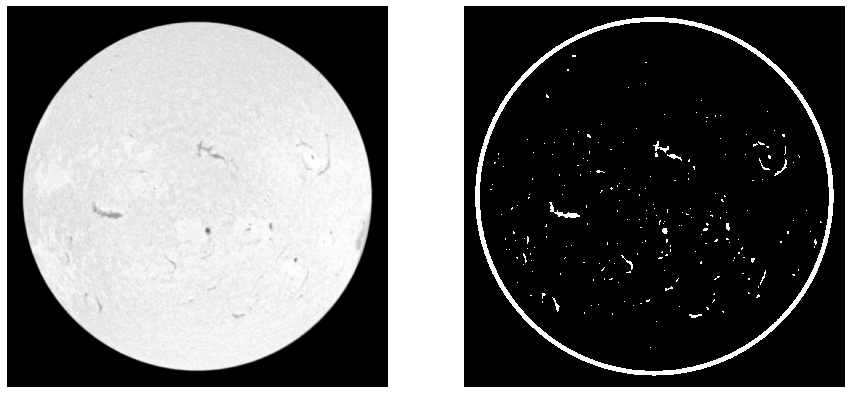

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  bool
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


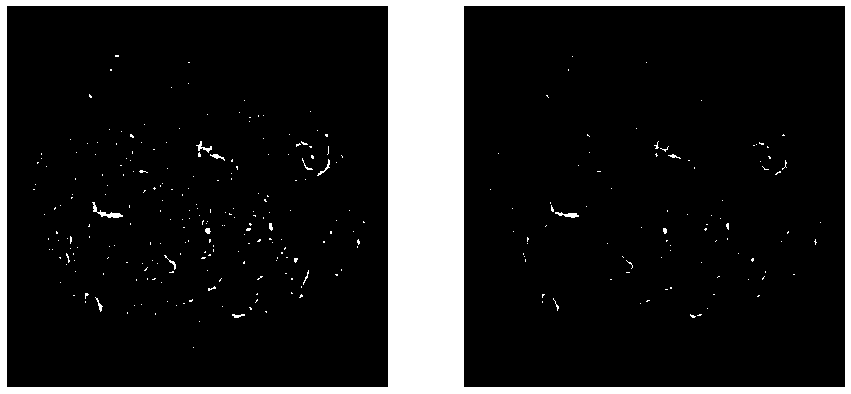

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


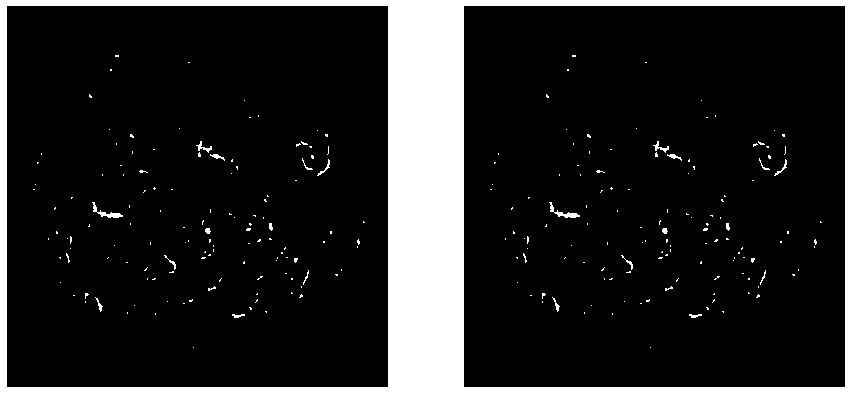

In [49]:
show_images(dark_experimental_img, dark_binary_local)
show_images(dark_binary_local_nl, dark_eroded)
show_images(dark_reconstructed, dark_without_small_objects)

### Segmentation of plages and flares

In [50]:
#lokální prahování pro světlé oblasti narušují příliš tmavé oblasti, funkce threshold_local pak totiž
#označuje oblasti kolem tmavých skvrn a filamentů jako detekované světlé oblasti, proto je třeba
#tmavé oblasti eliminovat, nejspíše použitím prahu V1 z algoritmu Zharkové
def bright_feature_extraction(image, median_mask, center, radius_big, mean_value, V1): 
    """
    Uses local thresholding and mathematical morphology to extract bright features from solar disc.
    
    Paramaters
    ----------
    image: ndarray
        Normalised solar image (with limb darkening and non-radial variations removed).
    median_mask: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    center: list with two integer values
        Solar disc center coordinates computed from original image (original size).
    radius_big: integer
        Solar disc radius computed from original image (original size).
    
    Returns
    -------
    bright_experimental_img: ndarray
        Solar image with too dark regions removed from solar disc (using V1 threshold 
        from Zharkova algorithm).
    bright_binary_local: ndarray
        Binary image obtained from local thresholding.
    gright_binary_local_nl:
        Binary image obtained from local thresholding with solar limb assign to
        the background.
    bright_eroded:
        Binary image calculated with binary morphological erosion operator.
    bright_reconstructed:
        Eroded binary image morphologically reconstructed.
    bright_without_small_objects:
        Binary image with too small object removed.
    
    """
    cx_big, cy_big = center
    bright_experimental_img = np.copy(image)
    width, height = bright_experimental_img.shape
    for x in range(0, height):
        for y in range(0, width):
            if (bright_experimental_img[y,x] < V1):
                bright_experimental_img[y,x] = median_mask[y,x]
    
    bright_experimental_img = ndimage.gaussian_filter(bright_experimental_img,3)
 
    #Lokální prahování pomocí "posouvacího okna", z nějž je spočten medián a s touto 
    #hodnotou je porovnáván zkoumaný pixel. 
    image_cp = np.copy(bright_experimental_img)
    block_size = 95
    #Offset se zatím zdá být vhodný 5% z průměrné intenzity
    offset_val = np.round(5 * mean_value / 100)
    local_thresh = threshold_local(image_cp, block_size, method='gaussian', offset=-offset_val)
    bright_binary_local = image_cp > local_thresh
   
    #odstranění okraje disku ze snímku po lokálním prahování
    bright_binary_local_nl = np.copy(bright_binary_local)
    width, height = bright_binary_local_nl.shape
    for x in range(0, height):
        for y in range(0, width):
            if ((cx_big - x)**2 + (cy_big - y)**2 > (radius_big - 30)**2):
                bright_binary_local_nl[y,x] = False
   
    #Eroze.
    selem = square(5)
    bright_eroded = binary_erosion(bright_binary_local_nl, selem)

    #Rekonstrukce.
    #selem = square(6)
    bright_reconstructed = reconstruction(bright_eroded, bright_binary_local_nl, method='dilation', selem=square(7))
    
    #Odstranění malých objektů
    bright_reconstructed_cp = np.copy(bright_reconstructed)
    bright_binary_reconstructed = bright_reconstructed > 0
    bright_without_small_objects = remove_small_objects(bright_binary_reconstructed, 10, connectivity=8)

    return (bright_experimental_img, bright_binary_local, bright_binary_local_nl, 
            bright_eroded, bright_reconstructed, bright_without_small_objects)

In [51]:
bright_result = bright_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], radius_big, 
                                          mean_array[0][0], V1)
bright_experimental_img = bright_result[0]
bright_binary_local = bright_result[1]
bright_binary_local_nl = bright_result[2]
bright_eroded = bright_result[3]
bright_reconstructed = bright_result[4]
bright_without_small_objects = bright_result[5]

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


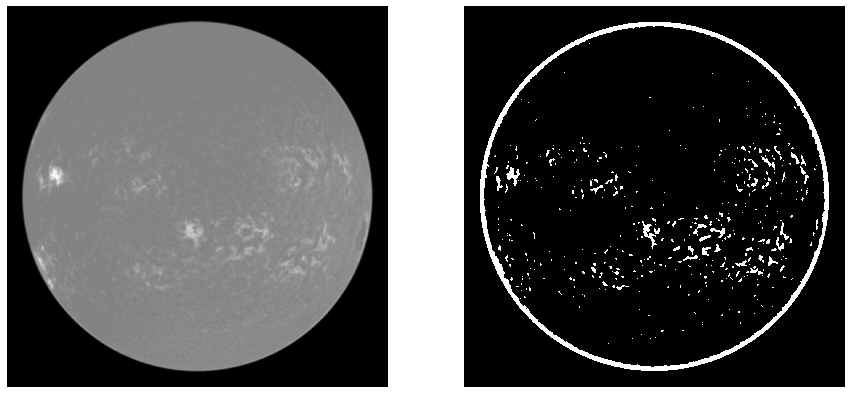

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  bool
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


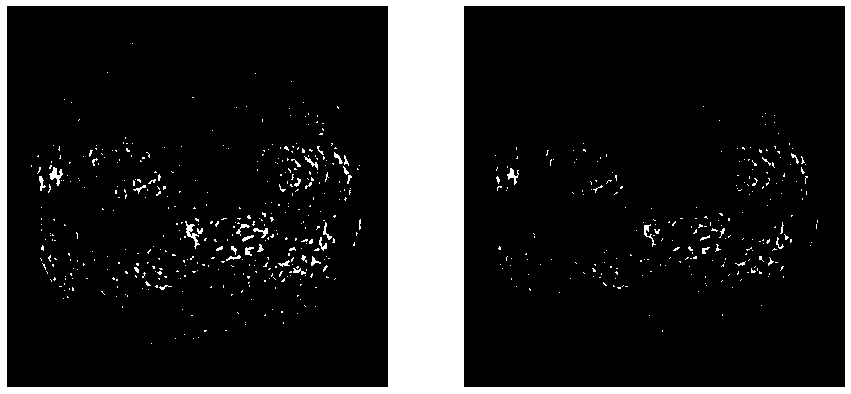

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


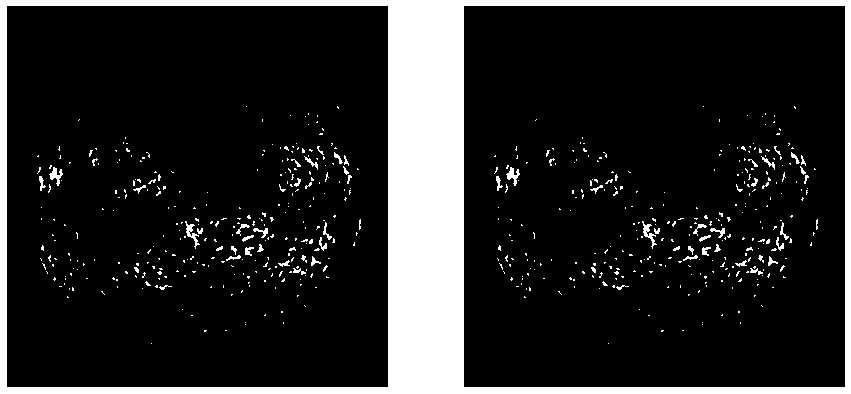

In [52]:
show_images(bright_experimental_img, bright_binary_local)
show_images(bright_binary_local_nl, bright_eroded)
show_images(bright_reconstructed, bright_without_small_objects)

### Region growing

In [53]:
# Po zkoušce měření vlastností objektů zjištěno, že růst je velmi důležitý! Po něm dostavám smysluplné výsledky,
# růst zaplní děravé oblasti (významné hlavně u skvrn, kde před růstem byla kruhovost 0.3 - 0.4, po něm 0.6  - 0.7),
# ale také u filametů, které hezky zaplní. Některé filamenty byly děravé jak cedník, výsledek měření byl v podstatě 
# k ničemu.

In [54]:
#zkontroluje sousedství pixelu, který !=0, když kritérium True, pak přidá sousednímu pixelu stejnou hodnotu do
#dark_regions_grown, sousedy pixelu uloží do stack + #dark_regions_grown, sousedy pixelu uloží do stack

def check(x, y, orig_image, grown_array, region_growing_thresh, objects_shade):
    '''
    Checking image pixels neighborhood for naive region growing.
    '''
    
    if objects_shade == 'dark':
        if orig_image[y - 1, x - 1] < region_growing_thresh:
            grown_array[y - 1, x - 1] = True
        if orig_image[y, x - 1] < region_growing_thresh:
            grown_array[y, x - 1] = True
        if orig_image[y + 1, x - 1] < region_growing_thresh:
            grown_array[y + 1, x - 1] = True
        if orig_image[y - 1, x] < region_growing_thresh:
            grown_array[y - 1, x] = True
        if orig_image[y + 1, x] < region_growing_thresh:
            grown_array[y + 1, x] = True
        if orig_image[y - 1, x + 1] < region_growing_thresh:
            grown_array[y - 1, x + 1] = True
        if orig_image[y, x + 1] < region_growing_thresh:
            grown_array[y, x + 1] = True
        if orig_image[y + 1, x + 1] < region_growing_thresh:
            grown_array[y + 1, x + 1] = True
    else:
        if orig_image[y - 1, x - 1] >= region_growing_thresh:
            grown_array[y - 1, x - 1] = True
        if orig_image[y, x - 1] >= region_growing_thresh:
            grown_array[y, x - 1] = True
        if orig_image[y + 1, x - 1] >= region_growing_thresh:
            grown_array[y + 1, x - 1] = True
        if orig_image[y - 1, x] >= region_growing_thresh:
            grown_array[y - 1, x] = True
        if orig_image[y + 1, x] >= region_growing_thresh:
            grown_array[y + 1, x] = True
        if orig_image[y - 1, x + 1] >= region_growing_thresh:
            grown_array[y - 1, x + 1] = True
        if orig_image[y, x + 1] >= region_growing_thresh:
            grown_array[y, x + 1] = True
        if orig_image[y + 1, x + 1] >= region_growing_thresh:
            grown_array[y + 1, x + 1] = True
        

In [55]:
def naive_region_growing(orig_image,image_for_growing, feature_type, mean_value):
    #orig_image = sol_img_norm
    #image_for_growing = dark_without_small_objects or bright_without_small_objects
    #feature_type = 'dark' or 'bright'
    #mean_value = mean_array[0][0] or mean_array[0,0]
    '''
    Check image pixels neighborhood with function check and grow one pixel thick layer.
    Should fill holes.
    '''
    
    ###DARK###
    if feature_type == 'dark':
        dark_regions_grown = np.zeros(image_for_growing.shape)
        width, height = image_for_growing.shape
        #prochází pixely snímku, když najde nenulovou hodnotu,přidá ji do dark_regions_grown
        #a zkontoluje pomocí check okolí
        for x in range(0, height):
            for y in range(0, width):
                if (image_for_growing[y,x] != False):
                    dark_regions_grown[y,x] = True
                    check(x, y, orig_image, dark_regions_grown, mean_value, 'dark')
        result = dark_regions_grown    
    
    ###BRIGHT###
    else:
        bright_regions_grown = np.zeros(image_for_growing.shape)
        width, height = image_for_growing.shape
        #prochází pixely snímku, když najde nenulovou hodnotu,přidá ji do dark_regions_grown
        #a zkontoluje pomocí check okolí
        for x in range(0, height):
            for y in range(0, width):
                if (image_for_growing[y,x] != False):
                    bright_regions_grown[y,x] = True
                    check(x, y, orig_image, bright_regions_grown, mean_value + 10, 'bright')
        result = bright_regions_grown
    
    return result

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  int16


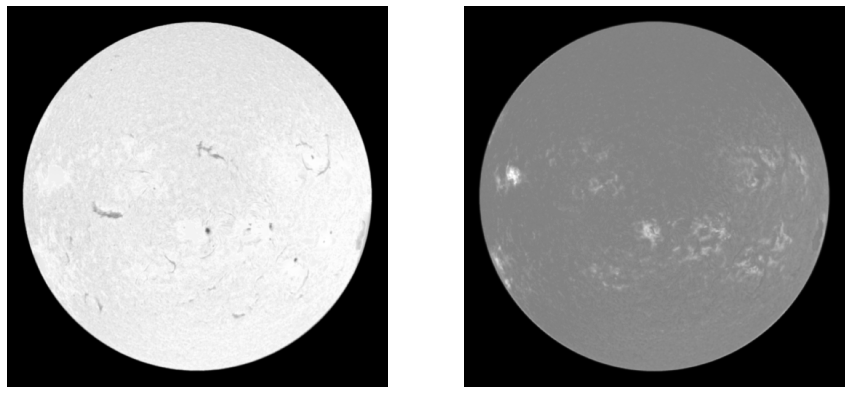

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  bool
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


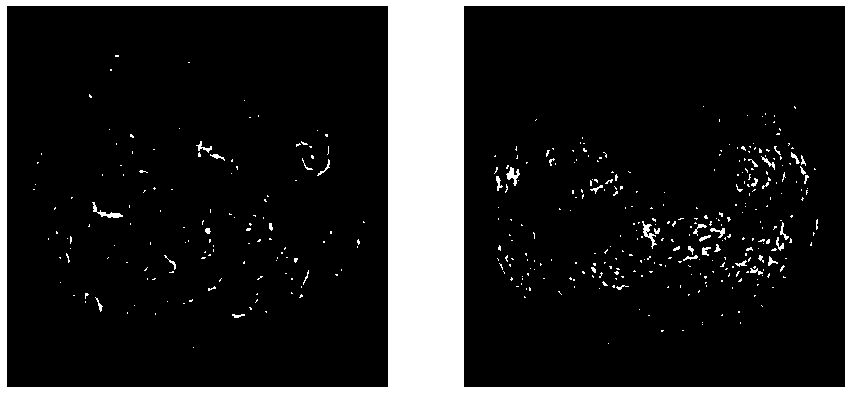

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float64


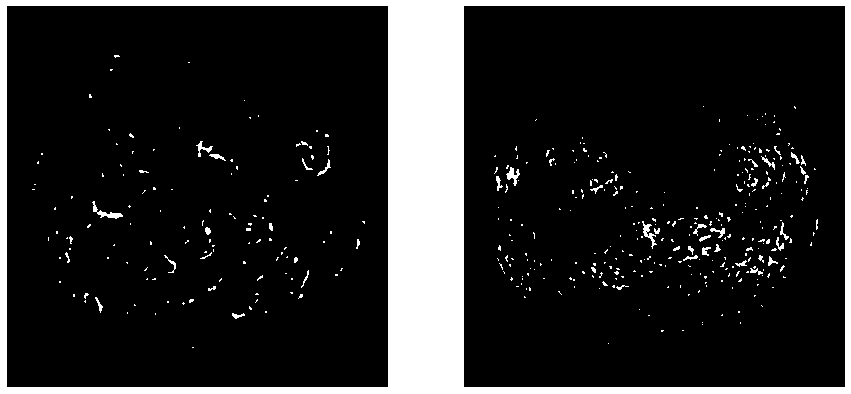

In [56]:
dark_regions_grown = naive_region_growing(sol_img_norm,dark_without_small_objects, 'dark', mean_array[0][0])
bright_regions_grown = naive_region_growing(sol_img_norm,bright_without_small_objects, 'dark', mean_array[0][0])

show_images(dark_experimental_img, bright_experimental_img)            
show_images(dark_without_small_objects, bright_without_small_objects)
show_images(dark_regions_grown, bright_regions_grown)

In [57]:
# Značky struktur po metodě růstu oblastí zobrazené v původním obrázku
def show_detected_regions(orig_image, dark_regions_img, bright_regions_img):
    labelled_img_dark = np.copy(orig_image)
    width, height = labelled_img_dark.shape
    for x in range(0, height):
        for y in range(0, width):
            if (dark_regions_img[y,x] != 0):
                labelled_img_dark[y,x] = dark_regions_img[y,x]

    labelled_img_bright = np.copy(orig_image)
    width, height = labelled_img_bright.shape
    for x in range(0, height):
        for y in range(0, width):
            if (bright_regions_img[y,x] != 0):
                labelled_img_bright[y,x] = bright_regions_img[y,x]

    show_images(labelled_img_dark, labelled_img_bright)

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  >i2
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  >i2


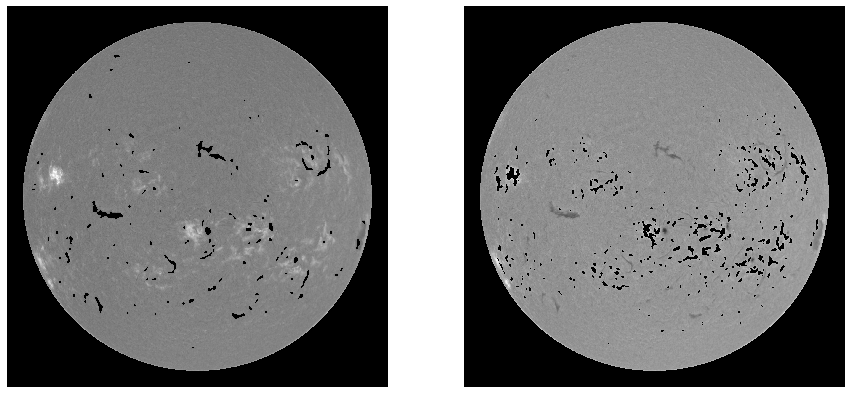

In [58]:
show_detected_regions(sol_img_norm, dark_regions_grown, bright_regions_grown)

### Region labelling after region growing method application

In [59]:
# značkování regionů po metodě růstu oblastí
dark_feature_labels_grown = measure.label(dark_regions_grown, background=0, return_num=False) 
bright_feature_labels_grown = measure.label(bright_regions_grown, background=0, return_num=False)

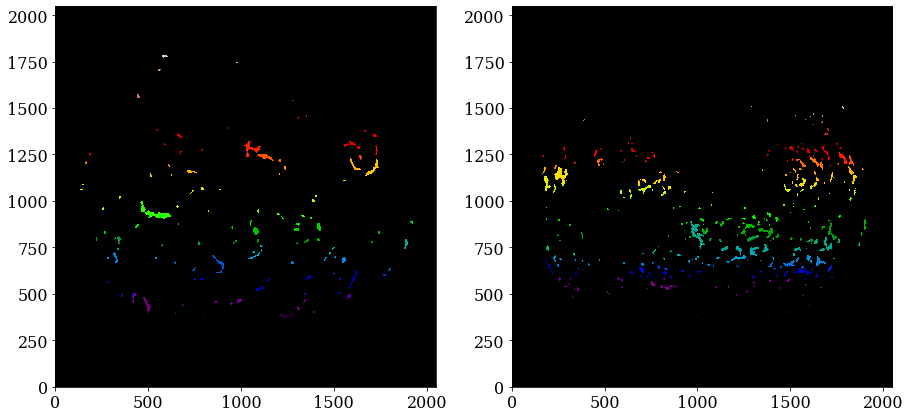

In [60]:
# vykreslení značek
plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(1, 2, 1)
plt.imshow(dark_feature_labels_grown, cmap='nipy_spectral', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(bright_feature_labels_grown, cmap='nipy_spectral', origin='lower')
plt.show()

### Region properties

Transformaci jenom na objekty nebo na celé slunce dvě, zachovávající plochy a úhly.
Kdyby jen objekty, najít si střed a promítnout na tečnou rovinu.

In [61]:
# Měření vlastností nalezených regionů po růstu oblastí, 
# např. obsah, obvod, momenty, ale také zobrazí výřez regionu z původního šedotónového obrázku
dark_props = regionprops(dark_feature_labels_grown, intensity_image=sol_img_norm)
bright_props = regionprops(bright_feature_labels_grown, intensity_image=sol_img_norm)

In [62]:
#Showing region intensity image and histogram
def show_region(region, feature_type):
    ###_DARK_###
    if feature_type == 'dark':
        image = dark_props[region].intensity_image
        min_val = np.amin(np.amin(image))
        max_val = np.amax(np.amax(image))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap=plt.cm.gray, origin='lower')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        histogram = plt.hist(image.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                             log=True)
        plt.show()
        
    ###_BRIGHT_###
    else:
        image = bright_props[region].intensity_image
        min_val = np.amin(np.amin(image))
        max_val = np.amax(np.amax(image))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap=plt.cm.gray, origin='lower')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        histogram = plt.hist(image.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                             log=True)
        plt.show()

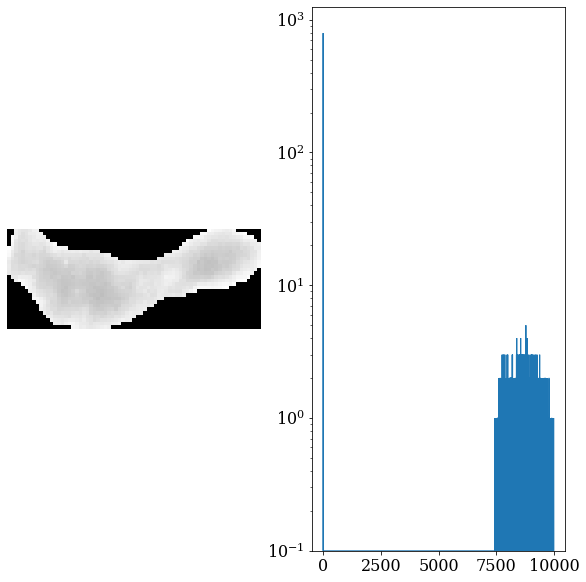

In [63]:
show_region(1, 'dark')

### Postel projection

In [64]:
##add projection for each feature (Postelova projekce)
#def postel_projection(region, centroid):
#    new_region...
#    ....
#    return new_region

### More feature properties

In [65]:
#Perimeter**2, používat normální obvod nebo konvexní?
def circularity(area, perimeter):
    return (4 * np.pi * area) / perimeter**2 #Použitá definice z (Osserman 1978)

def compactness(area, perimeter):
    return 4 * np.sqrt(np.pi*area) / perimeter #Compactness, Richardson(1961)

#Bounding box (min_row, min_col, max_row, max_col). 
#Pixels belonging to the bounding box are in the half-open interval [min_row; max_row) and [min_col; max_col).
#Jak přistupovat k prvkům tuple?
#elongation v rozsahu (0, 1)

#Elongation shape factor, odmocnina podílu dvou druhých momentu np.sqrt(i2 / i1)
#dark_props[i].moments, ale já počítám něco jiného...
def elongation(length, breadth): #vstupem osy elipsy
    return (length - breadth) / length

def aspect_ratio(length, breadth): #aspect ratio pro kruh i čtverek = 1, bude vždy větší nebo roven 1!
    return length / breadth #jak se bude lišit od eccentricity??? Asi nijak..

def relative_intensity(feature_intensity, bacground_disk_intensity):
    #jednoduché porovnání, když je menší jak 1, tak asi tmavé, když větší jak 1, tak světlé
    #ale bylo by lepší narvat do rozsahu 0 - 1, aby to bylo naškálováno... 0.5 by byla hranice
    #nebo -1 až 1, 0 by byla dělící hranice
     return (feature_intensity / bacground_disk_intensity)
    
#def radial_gradient(): #vlastní shape factor, má smysl jen pro elongation <= 0.5... zbytek bych dala 0...
#    return ...

#def real_centroid(): #přepočtení souřadnic středu objektu do slunečních souřadnic?
#    return (,)

#Ratio of fibre_length & fibre_width, čím menší, tím spíše filament?
def fibre_length(perimeter, area):
    return (perimeter - np.sqrt(np.abs(perimeter**2 - 16*area))) / 4

def fibre_width(area, fibre_length):
    return area / fibre_length

# pro filamenty se hodí parametr curl: length / fibre length (length = box length, fibre length délka páteře)
# fibre length = (perimeter - np.sqrt((perimeter)**2 - 16*area)) / 4
# As the measure of curl decreases, the degree to which they are “curled up” increases.

#The curl of an object measures the degree to which an object is “curled up”.
#As the measure of curl decreases, the degree to which they are “curled up” increases.
# Length should be box length..., I used length of major axis
#použít spíše bounding box length a délku kostry?
def curl(length, fibre_length): 
    return length / fibre_length

# Solidity: measures the density of an object
# Solidity = area / convex area
# A value of 1 signifies a solid object, and a value less than 1 will signify an object having an irregular boundary,
# or containing holes. --> is in scikit image already!

def bbox_length(bbox):
    row_dif = bbox[2]-bbox[0]
    col_dif = bbox[3] - bbox[1]
    if row_dif > col_dif:
        length = row_dif
    else:
        length = col_dif
    return length

def bbox_width(bbox):
    row_dif = bbox[2]-bbox[0]
    col_dif = bbox[3] - bbox[1]
    if row_dif > col_dif:
        width = col_dif
    else:
        width = row_dif
    return width

def complexity(binary_image, area):#, area): # more komplex objets are close to 1, less komplex (circle) are close to 0
    skeleton = skeletonize(binary_image)
    skeleton_area=0    
    width, height = skeleton.shape
    for x in range(0, height):
        for y in range(0, width):
            if skeleton[y,x] == True:
                skeleton_area += 1
            
    return skeleton_area / area#skeleton_area / area

def elongatedness(area, binary_image):
    thickness=0
    new_image = np.full(binary_image.shape, False)
    while (binary_image==new_image).all() != True:
        thickness+=1
        binary_image = binary_erosion(binary_image)
    return (2*thickness**2) / area

prodloužení:  0.6832758187515519
délka vlákna:  16.138853530591703
stočení:  4.90211589697149
šířka vlákna 74.04491265348186
poměr délky a šířky vlákna:  0.217960329106186
Složitost objektu pomocí morfologické kostry:  0.05355648535564853
Ohraničující box:  (368, 1210, 396, 1281) 28 71
Délka objektu z ohraničujícího boxu:  71
Šířka objektu z ohraničujícího boxu:  28
Poměr stran ohraničujícího boxu:  0.39436619718309857
Protažení pomocí morplogické eroze:  0.32803347280334727


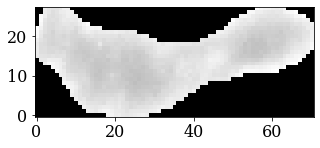

In [66]:
i=1
print('prodloužení: ',elongation(dark_props[i].major_axis_length, dark_props[i].minor_axis_length))
print('délka vlákna: ',fibre_length(dark_props[i].perimeter, dark_props[i].area))
fib = fibre_length(dark_props[i].perimeter, dark_props[i].area)
print('stočení: ', curl(dark_props[i].major_axis_length, fib))
print('šířka vlákna',fibre_width(dark_props[i].area, fib))
print('poměr délky a šířky vlákna: ',fibre_length(dark_props[i].perimeter, dark_props[i].area) / 
      fibre_width(dark_props[i].area, fib))
print('Složitost objektu pomocí morfologické kostry: ', complexity(dark_props[i].image, dark_props[i].area))
print('Ohraničující box: ', dark_props[i].bbox, dark_props[i].bbox[2]-dark_props[i].bbox[0], 
      dark_props[i].bbox[3] - dark_props[i].bbox[1])
print('Délka objektu z ohraničujícího boxu: ', bbox_length(dark_props[i].bbox))
print('Šířka objektu z ohraničujícího boxu: ', bbox_width(dark_props[i].bbox))
print('Poměr stran ohraničujícího boxu: ', bbox_width(dark_props[i].bbox) / bbox_length(dark_props[i].bbox))
print('Protažení pomocí morplogické eroze: ', elongatedness(dark_props[i].area,dark_props[i].image))

im = dark_props[i].intensity_image
#sk = skeletonize(dark_props[i].image)
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(im, cmap='gray', origin='lower')
#plt.imshow(sk, cmap='gray', origin='lower')
plt.show()

In [67]:
# Měření vlastností nalezených regionů po růstu oblastí, 
# např. obsah, obvod, momenty, ale také zobrazí výřez regionu z původního šedotónového obrázku
#dark_props = regionprops(dark_feature_labels_grown, intensity_image=sol_img_norm)
#bright_props = regionprops(bright_feature_labels_grown, intensity_image=sol_img_norm)
#Zde vytvořit tabulku vlastností, které nejsou definovány v measure, regionprops
#pro každý label spočítat
def extra_properties(labelled_image, orig_image, solar_radius, mean_value):
    '''
    Table of extra regions properties, which are not included in scikit 
    image region properties measure.  Needs definitions of these new 
    properties which are specified in this notebook. Will be improved in 
    the future.
    '''
    extra_prop_table = {}
    circ=[]
    comp=[]
    elon=[]
    inte=[]
    inte_min=[]
    inte_max=[]
    #fib_l=[]
    #fib_w=[]
    #curl_prop=[]
    compl=[]
    bbox_ratio=[]
    elongated=[]
    for region in regionprops(labelled_image, intensity_image=orig_image):
        circ.append(circularity(region.area, region.perimeter))
        comp.append(compactness(region.area, region.perimeter))
        elon.append(elongation(region.major_axis_length / (2*solar_radius), 
                               region.minor_axis_length / (2*solar_radius)))
        inte.append(relative_intensity(region.mean_intensity, mean_value)) #mean_value = mean_array[0,0]
        inte_min.append(relative_intensity(region.min_intensity, mean_value))
        inte_max.append(relative_intensity(region.max_intensity, mean_value))
        #fib_len=fibre_length(region.perimeter, region.area)
        #fib_l.append(fib_len)
        #fib_w.append(fibre_width(region.area, fib_len))
        #curl_prop.append(curl(region.major_axis_length / (2*solar_radius), fib_len))
        compl.append(complexity(region.image, region.area))
        bbox_ratio.append(bbox_width(region.bbox) / bbox_length(region.bbox))
        elongated.append(elongatedness(region.area, region.image))
    
    extra_prop_table['circularity'] = circ
    extra_prop_table['compactness'] = comp
    extra_prop_table['elongation'] = elon
    extra_prop_table['relative_intensity'] = inte
    extra_prop_table['relative_min_intensity'] = inte_min
    extra_prop_table['relative_max_intensity'] = inte_max
    #extra_prop_table['fibre_length'] = fib_l
    #extra_prop_table['fibre_width'] = fib_w
    #extra_prop_table['curl'] = curl_prop
    extra_prop_table['complexity'] = compl
    extra_prop_table['bbox_ratio'] = bbox_ratio
    extra_prop_table['elongatedness'] = elongated
      
    return extra_prop_table

In [68]:
#dictionaries with new properties, which should be merge with given tables from regionprops_table
dark_features = extra_properties(dark_feature_labels_grown, sol_img_norm, radius_big, mean_array[0][0])
bright_features = extra_properties(bright_feature_labels_grown, sol_img_norm, radius_big, mean_array[0][0])

In [69]:
#ukládá informace do slovníku, lze převést do dataFrame
#nefunguje extra_properties=(circularity, compactness,)??? Proč?
if measure.label(dark_regions_grown, background=0, return_num=True)[1] == 0:
    dark_table = {'label': [], 'centroid-0': [], 'centroid-1': [], 'bbox-0': [], 'bbox-1': [],
                    'bbox-2': [], 'bbox-3': [], 'mean_intensity': [], 
                    'min_intensity': [], 'max_intensity': [], 'orientation': [], 
                    'perimeter': [], 'area': [], 'eccentricity': [], 'solidity': [], 
                    'circularity': [], 'compactness': [], 'elongation': [], 'relative_intensity': [], 
                    'relative_min_intensity': [], 'relative_max_intensity': [], 'complexity': [], 
                    'bbox_ratio': [], 'elongatedness': []}     
else:
    dark_table = regionprops_table(dark_feature_labels_grown, intensity_image=sol_img_norm,
                                    properties=('label', 'centroid', 'bbox', 
                                                'mean_intensity', 'min_intensity', 'max_intensity', 
                                                'orientation', 'perimeter', 'area', 'eccentricity',
                                                 'solidity'),
                                    separator='-')
#Přidat sloupce s dalšími vlastnostmi
dark_table.update(dark_features)
dark_data = pd.DataFrame(dark_table) #přidat sloupce s dalšími vlastnostmi extra_properties
dark_data.head()
#dark_data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_dark.csv', index = False, header=True)

label  centroid-0  centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  \
0      1         210        1001     207     997     215    1007   
1      2         382        1242     368    1210     396    1281   
2      3         392         798     387     794     398     804   
3      4         397         648     393     644     403     653   
4      5         403        1391     399    1387     410    1398   

   mean_intensity  min_intensity  max_intensity      ...        solidity  \
0     9537.202899         8930.0        10004.0      ...        0.985714   
1     8648.671967         7439.0         9988.0      ...        0.771964   
2     9245.641304         8758.0         9770.0      ...        0.978723   
3     9216.000000         8809.0         9630.0      ...        0.975309   
4     9571.510417         9083.0         9962.0      ...        0.960000   

   circularity  compactness  elongation  relative_intensity  \
0     1.113951     2.110878    0.189529            0.952102   
1     0.461595     1.358816    0.683276            0.863399   
2     1.041722     2.041295    0.184836            0.922995   
3     1.068210     2.067085    0.070231            0.920036   
4     0.945073     1.944298    0.298493            0.955527   

   relative_min_intensity  relative_max_intensity  complexity  bbox_ratio  \
0                0.891484                0.998702    0.057971    0.800000   
1                0.742638                0.997105    0.053556    0.394366   
2                0.874314                0.975342    0.021739    0.909091   
3                0.879405                0.961366    0.037975    0.900000   
4                0.906759                0.994509    0.062500    1.000000   

   elongatedness  
0       1.043478  
1       0.328033  
2       0.782609  
3       1.240506  
4       0.750000  

[5 rows x 24 columns]

In [70]:
if measure.label(bright_regions_grown, background=0, return_num=True)[1] == 0:
    bright_table = {'label': [], 'centroid-0': [], 'centroid-1': [], 'bbox-0': [], 'bbox-1': [],
                    'bbox-2': [], 'bbox-3': [], 'mean_intensity': [], 
                    'min_intensity': [], 'max_intensity': [], 'orientation': [], 
                    'perimeter': [], 'area': [], 'eccentricity': [], 'solidity': [], 
                    'circularity': [], 'compactness': [], 'elongation': [], 'relative_intensity': [], 
                    'relative_min_intensity': [], 'relative_max_intensity': [], 'complexity': [], 
                    'bbox_ratio': [], 'elongatedness': []}    
else:
    bright_table = regionprops_table(bright_feature_labels_grown, intensity_image=sol_img_norm,
                                       properties=('label', 'centroid', 'bbox', 
                                                'mean_intensity', 'min_intensity', 'max_intensity', 
                                                'orientation', 'perimeter', 'area', 'eccentricity',
                                                 'solidity'),
                                      separator='-')
bright_table.update(bright_features)
bright_data = pd.DataFrame(bright_table) #přidat sloupce s dalšími vlastnostmi extra_properties
bright_data.head()
#bright_data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_bright.csv', index = False, header=True)

label  centroid-0  centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  \
0      1         231         778     229     775     235     783   
1      2         300        1065     294    1057     307    1073   
2      3         303        1176     298    1170     310    1184   
3      4         339        1280     333    1278     349    1284   
4      5         343        1484     340    1481     348    1490   

   mean_intensity  min_intensity  max_intensity      ...        solidity  \
0    11205.725000        10798.0        11642.0      ...        1.000000   
1    11481.911565        10271.0        12634.0      ...        0.980000   
2    11271.877778        10869.0        11879.0      ...        0.927835   
3    11328.148649        10857.0        11848.0      ...        0.913580   
4    11606.189655        10807.0        12121.0      ...        0.966667   

   circularity  compactness  elongation  relative_intensity  \
0     1.071715     2.070473    0.314810            1.118671   
1     0.952358     1.951777    0.173831            1.146243   
2     0.757986     1.741248    0.598580            1.125275   
3     0.689364     1.660559    0.664780            1.130892   
4     1.086564     2.084768    0.172081            1.158649   

   relative_min_intensity  relative_max_intensity  complexity  bbox_ratio  \
0                1.077967                1.162224    0.125000    0.750000   
1                1.025357                1.261256    0.054422    0.812500   
2                1.085055                1.185884    0.111111    0.857143   
3                1.083857                1.182789    0.135135    0.375000   
4                1.078866                1.210043    0.051724    0.888889   

   elongatedness  
0       1.250000  
1       1.102041  
2       0.355556  
3       0.675676  
4       0.862069  

[5 rows x 24 columns]

In [71]:
#Creating one table for all detected features
frames = [dark_data, bright_data]
solar_feature_table = pd.concat(frames, ignore_index=False)
#Vydělit plochu objektu plochou Slunce a obvod objektu obvodem Slunce
solar_feature_table['area'] = solar_feature_table['area'].div(np.pi*radius_big**2)
solar_feature_table['perimeter'] = solar_feature_table['perimeter'].div(2*np.pi*radius_big)
#Adding columns for features probability classification with zero value, which will be 
#overwrite in case of positive detection.
solar_feature_table['sunspot'] =0
solar_feature_table['filament'] =0
solar_feature_table['plage'] =0
solar_feature_table['flare'] =0
solar_feature_table.head()
#přidat sloupec s číslováním, přidat sloupec s filtrem, 
#přidat 4 sloupce nakonec pro objekty, nejprve prázdné, pak se do nich bude ukládat výsledek

label  centroid-0  centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  \
0      1         210        1001     207     997     215    1007   
1      2         382        1242     368    1210     396    1281   
2      3         392         798     387     794     398     804   
3      4         397         648     393     644     403     653   
4      5         403        1391     399    1387     410    1398   

   mean_intensity  min_intensity  max_intensity  ...    relative_intensity  \
0     9537.202899         8930.0        10004.0  ...              0.952102   
1     8648.671967         7439.0         9988.0  ...              0.863399   
2     9245.641304         8758.0         9770.0  ...              0.922995   
3     9216.000000         8809.0         9630.0  ...              0.920036   
4     9571.510417         9083.0         9962.0  ...              0.955527   

   relative_min_intensity  relative_max_intensity  complexity  bbox_ratio  \
0                0.891484                0.998702    0.057971    0.800000   
1                0.742638                0.997105    0.053556    0.394366   
2                0.874314                0.975342    0.021739    0.909091   
3                0.879405                0.961366    0.037975    0.900000   
4                0.906759                0.994509    0.062500    1.000000   

   elongatedness  sunspot  filament  plage  flare  
0       1.043478        0         0      0      0  
1       0.328033        0         0      0      0  
2       0.782609        0         0      0      0  
3       1.240506        0         0      0      0  
4       0.750000        0         0      0      0  

[5 rows x 28 columns]

422


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0648d14590>,
      dtype=object)

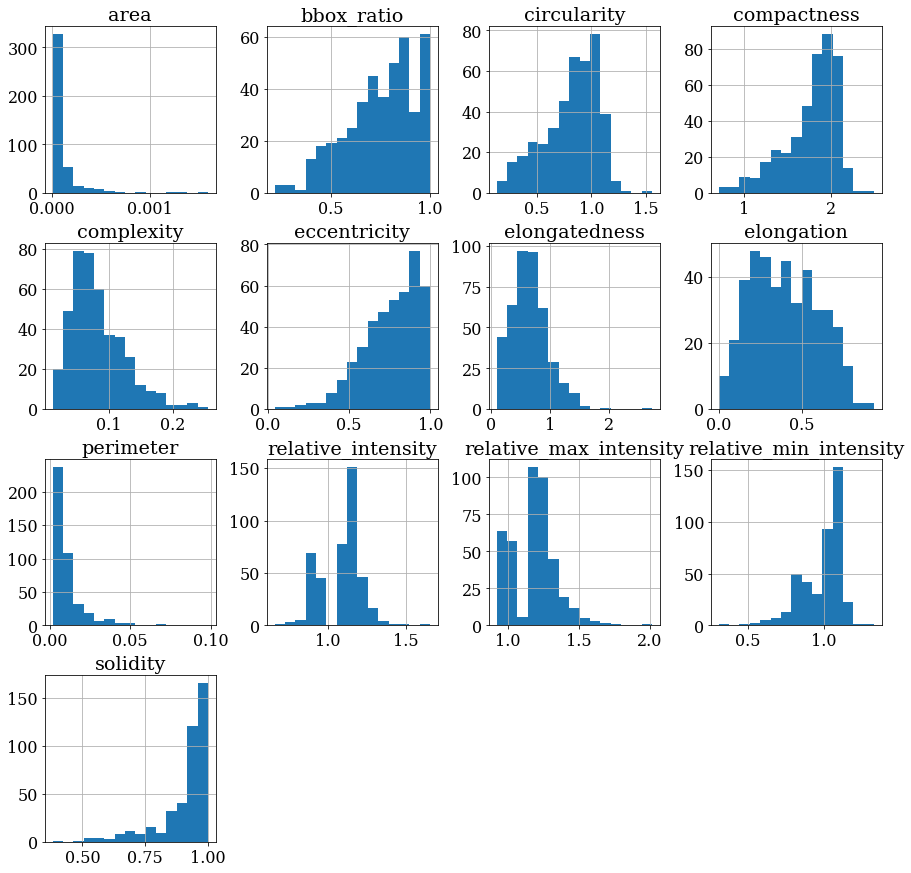

In [72]:
#histograms of chosen properties
for_bins = solar_feature_table.shape[0]
print(for_bins)
solar_feature_table.hist(column=['perimeter', 'area', 'eccentricity', 'solidity',
                                'circularity', 'compactness', 'elongation', 
                                'relative_intensity', 'relative_min_intensity', 'relative_max_intensity',
                                'complexity', 'bbox_ratio',
                                'elongatedness'], bins=15, figsize=(15,15))

### Classification

In [73]:
def classification(solar_image, file_format, obs_filter, reduction_coefficient, compute_ellipse=False):
    
    #Solar image loading and size reduction
    sol_img = image_loading(solar_image, file_format=file_format)
    sol_img_small = size_reduction(sol_img, reduction_coefficient)
        
    #Solar disk parameters calculation 
    hough_res = circle_hough_transform(sol_img_small)
    edges, cx, cy, radius = hough_res    
    hough_res_big = circle_hough_transform(sol_img)
    edges_big, cx_big, cy_big, radius_big = hough_res_big 
   
    if compute_ellipse==True:
        hough_res_el = ellipse_hough_transform(sol_img_small, radius)
        #Resampling of elliptical solar disc to circular shape doplnit
        
    mean_array = get_mean(sol_img_small, radius, [cx, cy])
    #Image_defects_detection doplnit
    
    #Limb darkening removal
    polar_img = transform_to_polar(sol_img_small, hough_res)    
    list_of_medians = median_of_rows(polar_img)
    max_value, x_data, y_data = data_for_fit(list_of_medians, radius)
    ld_fit = limb_darkening_fit(fit_function, x_data, y_data, radius)   
    polar_fit_mask = limb_darkening_mask_calculation(fit_function, list_of_medians, ld_fit, polar_img.shape)    
    cartesian_limb_darkening_mask = transform_to_cartesian(polar_fit_mask, sol_img_small.shape, hough_res,
                                                           mean_array[0][0])    
    cartesian_limb_darkening_mask_big = size_reduction(cartesian_limb_darkening_mask, 1/4)    
    sol_img_nld = limb_darkening_removal(sol_img_small, cartesian_limb_darkening_mask, 
                                         mean_array[0][0])    
    sol_img_nld_big = limb_darkening_removal(sol_img, cartesian_limb_darkening_mask_big, 
                                             mean_array[0][0])
    
    #Elimination of non-radial variation
    sol_img_small_norm, median_mask = first_median_filtering(sol_img_nld, radius, [cx, cy])
    V_M, V1, V2, no_feature_img = solar_feature_removal(sol_img_small_norm, median_mask)
    sol_img_norm, median_mask_second_big = nonradial_variation_removal(no_feature_img, sol_img, 
                                                                       [cx_big, cy_big],
                                                                   radius_big, sol_img_nld_big)
    
    #Feature detection
    dark_result = dark_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], 
                                          radius_big, mean_array[0][0], V2)
    dark_without_small_objects = dark_result[5] 
    
    bright_result = bright_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], 
                                              radius_big, mean_array[0][0], V1)
    bright_without_small_objects = bright_result[5] 
   
    #Region growing
    dark_regions_grown = naive_region_growing(sol_img_norm,dark_without_small_objects, 'dark', mean_array[0][0])
    bright_regions_grown = naive_region_growing(sol_img_norm,bright_without_small_objects, 'dark', mean_array[0][0])
    
    #Labelling aftef region growing
    dark_feature_labels_grown = measure.label(dark_regions_grown, background=0, return_num=False)
    bright_feature_labels_grown = measure.label(bright_regions_grown, background=0, return_num=False)
    
    #Defining some region properties
    def circularity(area, perimeter):
        return (4 * np.pi * area) / perimeter**2 #Použitá definice z (Osserman 1978)

    def compactness(area, perimeter):
        return 4 * np.sqrt(np.pi*area) / perimeter #Compactness, Richardson(1961)

    def elongation(length, breadth): #vstupem osy elipsy (nebo něco jiného, bbbox)
        return (length - breadth) / length

    def relative_intensity(feature_intensity, bacground_disk_intensity):
        return (feature_intensity / bacground_disk_intensity)
    
    def bbox_length(bbox):
        row_dif = bbox[2]-bbox[0]
        col_dif = bbox[3] - bbox[1]
        if row_dif > col_dif:
            length = row_dif
        else:
            length = col_dif
        return length

    def bbox_width(bbox):
        row_dif = bbox[2]-bbox[0]
        col_dif = bbox[3] - bbox[1]
        if row_dif > col_dif:
            width = col_dif
        else:
            width = row_dif
        return width

    def complexity(binary_image, area):
        skeleton = skeletonize(binary_image)
        skeleton_area=0    
        width, height = skeleton.shape
        for x in range(0, height):
            for y in range(0, width):
                if skeleton[y,x] == True:
                    skeleton_area += 1
            
        return skeleton_area / area

    def elongatedness(area, binary_image):
        thickness=0
        new_image = np.full(binary_image.shape, False)
        while (binary_image==new_image).all() != True:
            thickness+=1
            binary_image = binary_erosion(binary_image)
        return (2*thickness**2) / area    
    
    #Function which compute newly defined region properties and create dictionary (like regionprops_table)
    def extra_properties(labelled_image, orig_image, solar_radius, mean_value):
        extra_prop_table = {}
        circ=[]
        comp=[]
        elon=[]
        inte=[]
        inte_min=[]
        inte_max=[]
        compl=[]
        bbox_ratio=[]
        elongated=[]
        
        for region in regionprops(labelled_image, intensity_image=orig_image):
            circ.append(circularity(region.area, region.perimeter))
            comp.append(compactness(region.area, region.perimeter))
            elon.append(elongation(region.major_axis_length / (2*solar_radius), 
                                   region.minor_axis_length / (2*solar_radius)))
            inte.append(relative_intensity(region.mean_intensity, mean_value)) #mean_value = mean_array[0,0]
            inte_min.append(relative_intensity(region.min_intensity, mean_value))
            inte_max.append(relative_intensity(region.max_intensity, mean_value))
            compl.append(complexity(region.image, region.area))
            bbox_ratio.append(bbox_width(region.bbox) / bbox_length(region.bbox))
            elongated.append(elongatedness(region.area, region.image))

        extra_prop_table['circularity'] = circ
        extra_prop_table['compactness'] = comp
        extra_prop_table['elongation'] = elon
        extra_prop_table['relative_intensity'] = inte
        extra_prop_table['relative_min_intensity'] = inte_min
        extra_prop_table['relative_max_intensity'] = inte_max
        extra_prop_table['complexity'] = compl
        extra_prop_table['bbox_ratio'] = bbox_ratio
        extra_prop_table['elongatedness'] = elongated      

        return extra_prop_table
    
    dark_features = extra_properties(dark_feature_labels_grown, sol_img_norm, radius_big, mean_array[0][0])
    bright_features = extra_properties(bright_feature_labels_grown, sol_img_norm, radius_big, mean_array[0][0])

    #Dark regions properties to the table
    if measure.label(dark_regions_grown, background=0, return_num=True)[1] == 0:
        dark_table = {'label': [], 'centroid-0': [], 'centroid-1': [], 'bbox-0': [], 'bbox-1': [],
                        'bbox-2': [], 'bbox-3': [], 'mean_intensity': [], 
                        'min_intensity': [], 'max_intensity': [], 'orientation': [], 
                        'perimeter': [], 'area': [], 'eccentricity': [], 'solidity': [], 
                        'circularity': [], 'compactness': [], 'elongation': [], 'relative_intensity': [], 
                        'relative_min_intensity': [], 'relative_max_intensity': [], 'complexity': [], 
                        'bbox_ratio': [], 'elongatedness': []}     
    else:
        dark_table = regionprops_table(dark_feature_labels_grown, intensity_image=sol_img_norm,
                                    properties=('label', 'centroid', 'bbox', 
                                                'mean_intensity', 'min_intensity', 'max_intensity', 
                                                'orientation', 'perimeter', 'area', 'eccentricity',
                                                 'solidity'),
                                    separator='-')
    #Přidat sloupce s dalšími vlastnostmi
    dark_table.update(dark_features)
    dark_data = pd.DataFrame(dark_table) 

    #Bright regions properties to the table
    #Musím vyřešit hodnotu label! Ve chvíli, kdy se značkuje, tak přeznačkovat tak, aby maximální hodnota +1
    #značky u tmavých oblastí byla první značka u světlých oblastí, jinak se nebude dát dohledávat
    if measure.label(bright_regions_grown, background=0, return_num=True)[1] == 0:
        bright_table = {'label': [], 'centroid-0': [], 'centroid-1': [], 'bbox-0': [], 'bbox-1': [],
                        'bbox-2': [], 'bbox-3': [], 'mean_intensity': [], 
                        'min_intensity': [], 'max_intensity': [], 'orientation': [], 
                        'perimeter': [], 'area': [], 'eccentricity': [], 'solidity': [], 
                        'circularity': [], 'compactness': [], 'elongation': [], 'relative_intensity': [], 
                        'relative_min_intensity': [], 'relative_max_intensity': [], 'complexity': [], 
                        'bbox_ratio': [], 'elongatedness': []}    
    else:
        bright_table = regionprops_table(bright_feature_labels_grown, intensity_image=sol_img_norm,
                                       properties=('label', 'centroid', 'bbox', 
                                                'mean_intensity', 'min_intensity', 'max_intensity', 
                                                'orientation', 'perimeter', 'area', 'eccentricity',
                                                 'solidity'),
                                      separator='-')
    bright_table.update(bright_features)
    bright_data = pd.DataFrame(bright_table)
    
    frames = [dark_data, bright_data]
    solar_feature_table = pd.concat(frames, ignore_index=False) #ignore_index=False dokud nevyřeším značkování

    solar_feature_table['sunspot'] =0
    solar_feature_table['filament'] =0
    solar_feature_table['plage'] =0
    solar_feature_table['flare'] =0

    return solar_feature_table

Minimum and maximum values in list:  0.0 19434.021887440325
Práh pro odstranění pozadí ze seznamů četností a intenzit:  5048.290841854616
Hodnota intenzity, od které bude vše menší odstraněno ze seznamu intenzit:  5048.0056852834605
Maximum histogram frequency H_M:  296.0
Position of H_M in list:   5090
Intensity value corresponding to H_M:  10138.0114178692
Estimated frequences H1 and H2 using constant a1, a2:  2.96 ,  2.96
Found frequencies H1 and H2:  3.0 ,  3.0
Positions of nearest frequency values to H1, H2:  4353 ,  6035
Intensity value V_M, corresponding to H_M:  10138.0114178692 ,  296.0
Intensity values V1, V2 corresponding to H1, H2 (sunspots, filaments, flares, plages):  9401.010587826824 ,  11083.012482170481


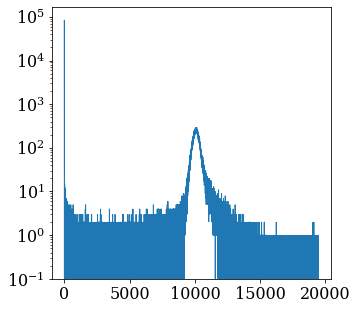

In [74]:
properties_calculated = classification(solar_image='data/BBSO/fits/bbso_halph_fl_20140708_164624.fts', 
                               file_format='fits', obs_filter='HALPHA', reduction_coefficient=4, 
                               compute_ellipse=False)
#přidat výpis počtu celkem nalezených objektů
#classificated.to_csv (r'tables/kanz_halph_fi_20150517_062736_test.csv', index = False, header=True)

In [75]:
properties_calculated.head()

label  centroid-0  centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  \
0      1         210        1001     207     997     215    1007   
1      2         382        1242     368    1210     396    1281   
2      3         392         798     387     794     398     804   
3      4         397         648     393     644     403     653   
4      5         403        1391     399    1387     410    1398   

   mean_intensity  min_intensity  max_intensity  ...    relative_intensity  \
0     9537.202899         8930.0        10004.0  ...              0.952102   
1     8648.671967         7439.0         9988.0  ...              0.863399   
2     9245.641304         8758.0         9770.0  ...              0.922995   
3     9216.000000         8809.0         9630.0  ...              0.920036   
4     9571.510417         9083.0         9962.0  ...              0.955527   

   relative_min_intensity  relative_max_intensity  complexity  bbox_ratio  \
0                0.891484                0.998702    0.057971    0.800000   
1                0.742638                0.997105    0.053556    0.394366   
2                0.874314                0.975342    0.021739    0.909091   
3                0.879405                0.961366    0.037975    0.900000   
4                0.906759                0.994509    0.062500    1.000000   

   elongatedness  sunspot  filament  plage  flare  
0       1.043478        0         0      0      0  
1       0.328033        0         0      0      0  
2       0.782609        0         0      0      0  
3       1.240506        0         0      0      0  
4       0.750000        0         0      0      0  

[5 rows x 28 columns]

In [76]:
#Finále, do tabulky jsou přidány 4 sloupečky s pravděpodobnostmi, s jakými jsou to skvrny, filamenty atd.
# Až zde dojde k uložení do PC
def solar_feature_classificator(CSV_table_path, classification_matrix):
    #1-2 = reduction coefficient 2 -> zmenšení na polovinu
    #1-4 = reduction coefficient 4 -> zmenšení na čtvrtinu
    #1-1 = reduction coefficient 1 -> beze změny
    #3-2 = reduction coefficient 2/3 -> zvětšení 1.5krát 
    #data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_1-2.csv', index = False, header=True)
    #data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_1-4.csv', index = False, header=True)
    #data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_1-1.csv', index = False, header=True)
    #data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_3-2.csv', index = False, header=True)
    return classificated

In [77]:
#tabulka jen jedna pro stejné zvětšení, jasné a tmavé oblasti sloučit do jedné tabulky se stejnou hlavičkou
#pro jeden snímek třeba 4 tabulky, každá pro jiné zvětšení, uživatel si pak vyhodnotí sám, 
#zda je objekt podsegmentován nebo naopak

#lze mít konfigurační soubor, kde budou váhy pro jednotlivé vlastnosti (s jako velkou vahou beru v úvahu kruhovost 
#apod.)

#výstup v heliocentrických souřadnicích

#jeden sloupec skrz kvalitu snímku (projde průměrnou intenzitu v jednotlicých sekcích a porovná)

#pravděpodobnosti se asi budou násobit? A váhy budou exponenty?

#odstranit vše pod úrovní seengu (1 oblouková vteřina)

#For creating CSV tables of found regions with the same name as input image

import os
images = os.listdir('data/KSO_CONTINUUM')
#print(images)

for img in images:
    print(img)
    classificated = classification(solar_image='data/KSO_CONTINUUM/'+str(img), 
                               file_format='fits', obs_filter='HALPHA', reduction_coefficient=4, 
                               compute_ellipse=False)
    img_name=img[0:-4]
    #print(img_name)
    classificated.to_csv (r'tables/KSO-C/'+str(img_name)+'.csv', index = False, header=True)

221
794


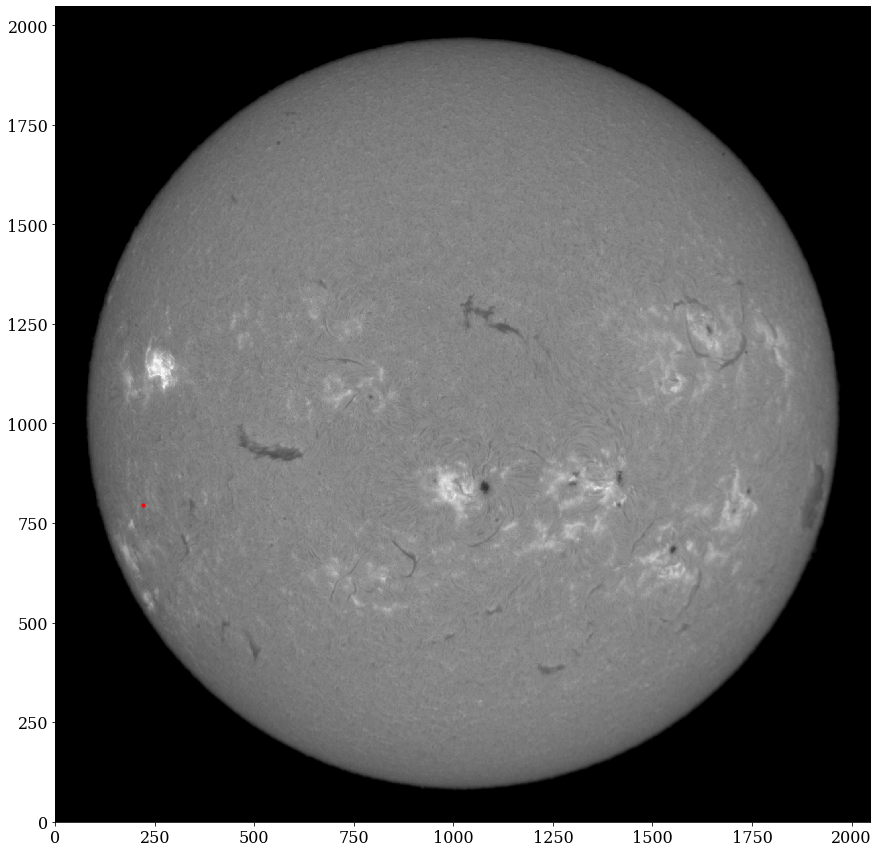

In [78]:
#For manually created testing sets
df = pd.read_csv('tables/BBSO/bbso_halph_fl_20140708_164624.csv')

row = df.iloc[36] 
col1 = ["centroid-0"]
col2 = ["centroid-1"]
y=int(row[col1])
x=int(row[col2])
print(x)
print(y)
#row2 = df.iloc[0] 
#print(row2)

sol_img = image_loading('data/BBSO/fits/bbso_halph_fl_20140708_164624.fts')

plt.rcParams['figure.figsize'] = [15, 15] # nastavení velikosti okna, které zobrazuje snímek
plt.imshow(sol_img, cmap="gray",origin='lower') # zobrazení snímku, 'lower' place [0,0] in lower left corner

plt.plot(x, y, "or", markersize=3)

In [79]:
#For drawing centroids of features into image
df = pd.read_csv('tables/BBSO/bbso_halph_fl_20140708_164624.csv')
sunspot_table = df.loc[df['sunspot'] == 1]
filament_table = df.loc[df['filament'] == 1]
plage_table = df.loc[df['plage'] == 1]
flare_table = df.loc[df['flare'] == 1]

In [80]:
#sunspot_table
#filament_table
#plage_table
#flare_table

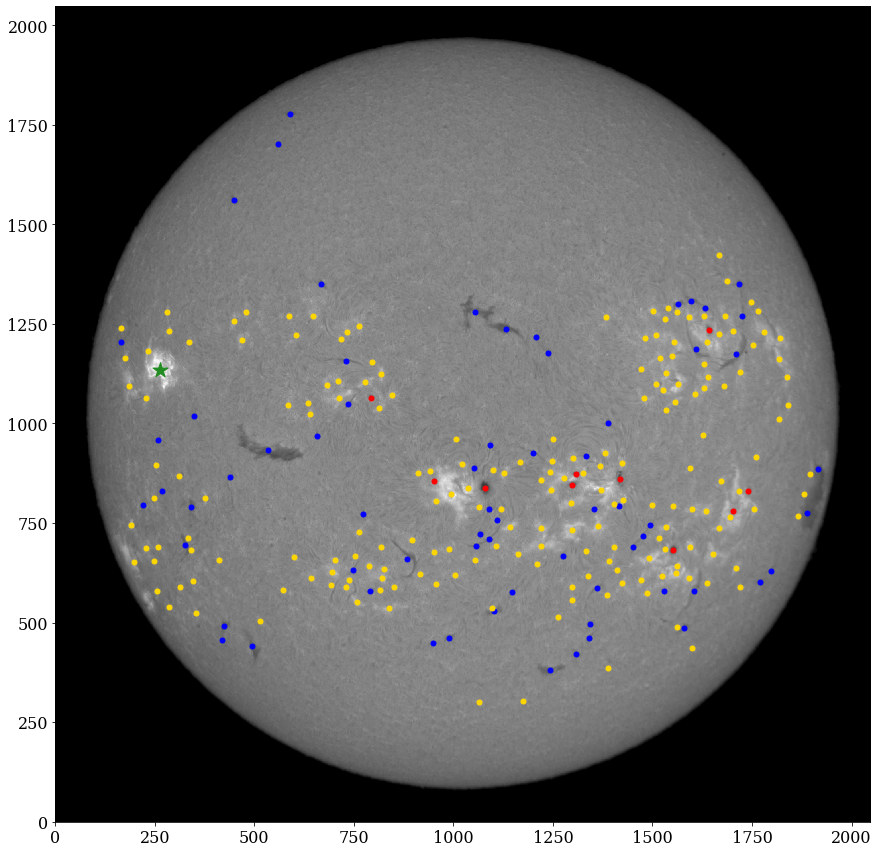

In [81]:
#sunspot list for plot
y_sun=[]
x_sun=[]
for i in range(0, 10):
    row_sunspot = sunspot_table.iloc[i]
    col1_sunspot = ["centroid-0"]
    col2_sunspot = ["centroid-1"]
    y_sun.append((row_sunspot[col1_sunspot])[0])
    x_sun.append((row_sunspot[col2_sunspot])[0])

#filament list for plot
y_fil=[]
x_fil=[]
for j in range(0, 66):
    row_fil = filament_table.iloc[j] 
    col1_fil = ["centroid-0"]
    col2_fil = ["centroid-1"]
    y_fil.append((row_fil[col1_fil])[0])
    x_fil.append((row_fil[col2_fil])[0])

#plage list for plot
y_pl=[]
x_pl=[]
for k in range(0, 193):
    row_pl = plage_table.iloc[k] 
    col1_pl = ["centroid-0"]
    col2_pl = ["centroid-1"]
    y_pl.append((row_pl[col1_pl])[0])
    x_pl.append((row_pl[col2_pl])[0])

#flare list for plot
y_fla=[]
x_fla=[]
for l in range(0, 1):
    row_fla = flare_table.iloc[l] 
    col1_fla = ["centroid-0"]
    col2_fla = ["centroid-1"]
    y_fla.append((row_fla[col1_fla])[0])
    x_fla.append((row_fla[col2_fla])[0])
    
sol_img = image_loading('data/BBSO/fits/bbso_halph_fl_20140708_164624.fts')

plt.rcParams['figure.figsize'] = [15, 15] # nastavení velikosti okna, které zobrazuje snímek
plt.imshow(sol_img, cmap="gray",origin='lower') # zobrazení snímku, 'lower' place [0,0] in lower left corner

plt.scatter(x_sun, y_sun, marker='o', c="red", s=25)
plt.scatter(x_fil, y_fil, marker='o', c="b",s=25)
plt.scatter(x_pl, y_pl, marker='o', c='gold', s=25)
plt.scatter(x_fla, y_fla, marker='*', c="forestgreen", s=250)
plt.show()